In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor
import os
from tqdm import tqdm
from sklearn.impute import KNNImputer
from sklearn.base import clone
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.optimize import minimize
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor

import optuna
from scipy import stats


In [176]:
# Constants
SEED = 42

In [ ]:
# Loading the datasets
train_file_path = "/kaggle/input/child-mind-institute-problematic-internet-use/train.csv"
train_df = pd.read_csv(train_file_path)
test_file_path = "/kaggle/input/child-mind-institute-problematic-internet-use/test.csv"
test_df = pd.read_csv(test_file_path)
df = train_df

# DATA EXPLORATION

In [9]:
# Basic Info about Dataset
print("\n🔹 Dataset Info:")
print(df.info())


🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898

In [10]:
# Checking for Missing Values
print("\n🔍 Missing Values Count:")
print(df.isnull().sum())


🔍 Missing Values Count:
id                                           0
Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
                                          ... 
SDS-SDS_Total_Raw                         1351
SDS-SDS_Total_T                           1354
PreInt_EduHx-Season                        420
PreInt_EduHx-computerinternet_hoursday     659
sii                                       1224
Length: 82, dtype: int64


In [11]:
# Summary Statistics
print("\n📊 Summary Statistics (Numerical Features):")
print(df.describe())


📊 Summary Statistics (Numerical Features):
       Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
count      3960.000000      3960.000000      2421.000000   3022.000000   
mean         10.433586         0.372727        65.454771     19.331929   
std           3.574648         0.483591        22.341862      5.113934   
min           5.000000         0.000000        25.000000      0.000000   
25%           8.000000         0.000000        59.000000     15.869350   
50%          10.000000         0.000000        65.000000     17.937682   
75%          13.000000         1.000000        75.000000     21.571244   
max          22.000000         1.000000       999.000000     59.132048   

       Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
count      3027.000000      3076.000000                    898.000000   
mean         55.946713        89.038615                     27.278508   
std           7.473764        44.569040                      5.567287 

In [12]:
# Identify Categorical & Numerical Columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

print(f"\n📝 Categorical Columns: {list(categorical_cols)}")
print(f"\n🔢 Numerical Columns: {list(numerical_cols)}")


📝 Categorical Columns: ['id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']

🔢 Numerical Columns: ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA

In [13]:
len(numerical_cols)

70

In [14]:
## Correlation
covariance_matrix = df.select_dtypes(include=['float64','int64']).corr()
display(covariance_matrix)
covariance_matrix.to_csv("covariance_matrix.csv")

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
Basic_Demos-Age,1.000000,0.064004,-0.009994,0.492112,0.880274,0.748149,0.609601,0.107960,-0.218527,0.263875,...,0.085805,0.286888,0.159826,0.303259,0.286309,0.409559,0.037317,0.037115,0.441822,0.365990
Basic_Demos-Sex,0.064004,1.000000,0.075470,0.025793,-0.014454,0.003245,-0.020013,0.002076,0.026675,-0.025256,...,-0.097824,-0.102390,-0.110080,-0.104911,-0.067966,-0.093648,-0.020122,-0.018508,-0.000579,-0.100148
CGAS-CGAS_Score,-0.009994,0.075470,1.000000,-0.094074,-0.023185,-0.076399,-0.076116,-0.005292,-0.010108,-0.021392,...,-0.065687,-0.047770,-0.067922,-0.065210,-0.067920,-0.070542,-0.145369,-0.148457,-0.021596,-0.085261
Physical-BMI,0.492112,0.025793,-0.094074,1.000000,0.487097,0.865662,0.892149,0.141795,-0.036955,0.312045,...,0.071017,0.152122,0.100032,0.181208,0.161034,0.240858,0.087655,0.086185,0.296709,0.221125
Physical-Height,0.880274,-0.014454,-0.023185,0.487097,1.000000,0.833844,0.688033,0.115724,-0.217080,0.299157,...,0.112369,0.300590,0.184409,0.307084,0.292542,0.420765,0.036687,0.036478,0.399367,0.373530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCIAT-PCIAT_Total,0.409559,-0.093648,-0.070542,0.240858,0.420765,0.353048,0.327013,0.069321,-0.037594,0.147081,...,0.769422,0.823708,0.802030,0.737243,0.754277,1.000000,0.234432,0.237718,0.374124,0.899681
SDS-SDS_Total_Raw,0.037317,-0.020122,-0.145369,0.087655,0.036687,0.075098,0.089831,0.006702,0.049194,0.036562,...,0.250015,0.177323,0.239387,0.171186,0.209167,0.234432,1.000000,0.996134,0.083501,0.229692
SDS-SDS_Total_T,0.037115,-0.018508,-0.148457,0.086185,0.036478,0.073482,0.091152,0.008502,0.047932,0.038317,...,0.252715,0.180220,0.241844,0.173366,0.209338,0.237718,0.996134,1.000000,0.086050,0.232982
PreInt_EduHx-computerinternet_hoursday,0.441822,-0.000579,-0.021596,0.296709,0.399367,0.375851,0.371418,0.074258,-0.073453,0.137728,...,0.180736,0.299658,0.223794,0.290488,0.245310,0.374124,0.083501,0.086050,1.000000,0.336526


In [15]:
numeric_df = train_df.select_dtypes(include='number')

min_max_df = pd.DataFrame({
    'Min': numeric_df.min(),
    'Max': numeric_df.max()
}).sort_values(by='Min', ascending=True)  # or sort by 'Max' if preferred

print(min_max_df)

                        Min          Max
BIA-BIA_Fat     -8745.08000     153.8200
BIA-BIA_FMI      -194.16300      28.2515
BIA-BIA_BMC        -7.78961    4115.3600
sii                 0.00000       3.0000
FGC-FGC_TL_Zone     0.00000       1.0000
...                     ...          ...
BIA-BIA_FFM        28.90040    8799.0800
Physical-Height    33.00000      78.5000
SDS-SDS_Total_T    38.00000     100.0000
BIA-BIA_BMR       813.39700   83152.2000
BIA-BIA_DEE      1073.45000  124728.0000

[70 rows x 2 columns]


# BASIC DATA CLEANING

In [16]:
def clean_data(df):
    
    season_colums = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_colums, axis=1) # Removes columns with 'Season' in the name
    
    df = df.drop(columns=['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec'])
    
    df["BIA-BIA_Fat"] = df["BIA-BIA_Fat"].abs() # Replaces negative values with positive values

    df["BIA-BIA_FMI"] = df["BIA-BIA_FMI"].abs() # Replaces negative values with positive values

    df.loc[df["BIA-BIA_Fat"] > 65, "BIA-BIA_Fat"] = np.nan # Replaces values greater than 65 with NaN - more than 65% body fat is not possible

    df.loc[df["BIA-BIA_Fat"] < 5, "BIA-BIA_Fat"] = np.nan # Replaces values less than 5 with NaN - less 5% body fat is not possible

    df.loc[df["BIA-BIA_FMI"] > 40, "BIA-BIA_FMI"] = np.nan # Replaces values greater than 40 with NaN

    df[['FGC-FGC_GSND', 'FGC-FGC_GSD']] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].clip(lower=0, upper=100) # Replaces values less than 0 with 0 and values greater than 100 with 100

    df.loc[df["BIA-BIA_BMR"] > 4000, "BIA-BIA_BMR"] = np.nan # Replaces values greater than 4000 with NaN

    df.loc[df["BIA-BIA_DEE"] > 8000, "BIA-BIA_DEE"] = np.nan # Replaces values greater than 8000 with NaN

    df["BIA-BIA_BMC"] = df["BIA-BIA_BMC"].abs() # Replaces negative values with positive values

    df[['BIA-BIA_BMC']] = df[['BIA-BIA_BMC']].clip(lower=0, upper=10) # Replaces values less than 0 with 0 and values greater than 10 with 10

    df.loc[df["BIA-BIA_BMC"] == 0, "BIA-BIA_BMC"] = np.nan # Replaces values equal to 0 with NaN

    df.loc[df["BIA-BIA_FFM"] > 400, "BIA-BIA_FFM"] = np.nan # Replaces values greater than 400 with NaN

    df.loc[df["BIA-BIA_ECW"] > 100, "BIA-BIA_ECW"] = np.nan # Replaces values greater than 100 with NaN

    df.loc[df["BIA-BIA_ICW"] > 100, "BIA-BIA_ICW"] = np.nan # Replaces values greater than 100 with NaN

    df.loc[df["BIA-BIA_LDM"] > 100, "BIA-BIA_LDM"] = np.nan # Replaces values greater than 100 with NaN

    df.loc[df["BIA-BIA_LST"] > 300, "BIA-BIA_LST"] = np.nan # Replaces values greater than 300 with NaN

    df.loc[df["BIA-BIA_TBW"] > 300, "BIA-BIA_TBW"] = np.nan # Replaces values greater than 300 with NaN

    df.loc[df["BIA-BIA_SMM"] > 300, "BIA-BIA_SMM"] = np.nan # Replaces values greater than 300 with NaN

    df.loc[df["Physical-Height"] == 0, "Physical-Height"] = np.nan # Replaces values equal to 0 with NaN

    df.loc[df["Physical-Weight"] == 0, "Physical-Weight"] = np.nan # Replaces values equal to 0 with NaN
    
    df.loc[df['CGAS-CGAS_Score'] == 999, 'CGAS-CGAS_Score'] = np.nan #Replace the single outlier CGAS Score with NAN

    df['PAQ_Total'] = df['PAQ_C-PAQ_C_Total'].fillna(df['PAQ_A-PAQ_A_Total']) # Fills missing values in PAQ_Total with values from PAQ_A-PAQ_A_Total

    df = df.drop('PAQ_C-PAQ_C_Total', axis=1) 
    df = df.drop('PAQ_A-PAQ_A_Total', axis=1)
    
    # Removes columns with 'Zone' in the name because they are not properly assigned - there is a lot of noise in the data.
    df = df.drop(columns=['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone'])
    
    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df) 

In [17]:
# Quick function to display the statistics of a column
def get_statistic(df_col):
    print(df_col.describe())

def assign_groups(age):
    thresholds = [5, 10, 15, 18, 22] # Define the age thresholds for grouping.
    for i, j in enumerate(thresholds):
        if age <= j:
            return i
    return np.nan

def group_statistics(df, column):
    mean_value = df.groupby('age_group')[column].mean() # Calculate the mean value of the column for each age group.
    print(mean_value)

train_df['age_group'] = train_df['Basic_Demos-Age'].apply(assign_groups) # Apply the function to the 'Demographics-Age' column.
test_df['age_group'] = test_df['Basic_Demos-Age'].apply(assign_groups) # Apply the function to the 'Demographics-Age' column.



# DATA IMPUTATION

In [18]:
pd.reset_option('display.max_rows')

In [19]:
train_df

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,PAQ_Total,age_group
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,4.0,2.0,4.0,55.0,NaN,NaN,3.0,2.0,NaN,0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,0.0,0.0,0.0,0.0,46.0,64.0,0.0,0.0,2.340,1
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,2.0,1.0,1.0,28.0,38.0,54.0,2.0,0.0,2.170,1
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,3.0,4.0,1.0,44.0,31.0,45.0,0.0,1.0,2.451,1
4,0016bb22,18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.040,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,13,0,60.0,16.362460,59.5,82.4,NaN,71.0,70.0,...,1.0,1.0,0.0,32.0,35.0,50.0,1.0,1.0,3.260,2
3956,ffa9794a,10,0,NaN,18.764678,53.5,76.4,27.0,60.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.340,1
3957,ffcd4dbd,11,0,68.0,21.441500,60.0,109.8,NaN,79.0,99.0,...,1.0,0.0,1.0,31.0,56.0,77.0,0.0,1.0,2.729,2
3958,ffed1dd5,13,0,70.0,12.235895,70.7,87.0,NaN,59.0,61.0,...,1.0,1.0,1.0,19.0,33.0,47.0,1.0,0.0,3.300,2


In [20]:
pd.set_option('display.max_rows', None)

missing_cols = train_df.isna().sum()
missing_cols = missing_cols[missing_cols > 0]
print(missing_cols)

CGAS-CGAS_Score                           1540
Physical-BMI                               938
Physical-Height                            933
Physical-Weight                            945
Physical-Waist_Circumference              3062
Physical-Diastolic_BP                     1006
Physical-HeartRate                         993
Physical-Systolic_BP                      1006
FGC-FGC_CU                                1638
FGC-FGC_GSND                              2886
FGC-FGC_GSD                               2886
FGC-FGC_PU                                1650
FGC-FGC_SRL                               1655
FGC-FGC_SRR                               1653
FGC-FGC_TL                                1636
BIA-BIA_Activity_Level_num                1969
BIA-BIA_BMC                               1969
BIA-BIA_BMI                               1969
BIA-BIA_BMR                               1971
BIA-BIA_DEE                               1971
BIA-BIA_ECW                               1974
BIA-BIA_FFM  

In [21]:
corr = pd.DataFrame(train_df.select_dtypes(include='number').corr()['PCIAT-PCIAT_Total'].sort_values(ascending = False))
corr

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
sii,0.899681
PCIAT-PCIAT_05,0.830993
PCIAT-PCIAT_15,0.823996
PCIAT-PCIAT_17,0.823708
PCIAT-PCIAT_03,0.823336
PCIAT-PCIAT_18,0.802030
PCIAT-PCIAT_02,0.788802
PCIAT-PCIAT_13,0.771990
PCIAT-PCIAT_08,0.770499


### Height and Weight using KNN Imputation

In [22]:
# 1. Getting all columns with missing values
missing_cols = train_df.columns[train_df.isna().any()]

# 2. Getting the correlation matrix (numeric columns only)
corr_matrix = train_df.corr(numeric_only=True)

# 3. Defining our target columns
target_cols = ['Physical-Height', 'Physical-Weight']

# 4. Finding non-missing columns
non_missing_cols = [col for col in train_df.columns if col not in missing_cols]

# 5. For each target, getting sorted correlations with non-missing columns
for target in target_cols:
    print(f"\nTop correlated non-missing columns with {target}:\n")
    if target not in corr_matrix:
        print("No correlation available (likely too many NaNs).")
        continue
    correlations = corr_matrix[target].dropna()
    correlations = correlations[correlations.index.isin(non_missing_cols) & (correlations.index != target)]
    print(f"Found {len(correlations)} valid correlations")
    print(correlations.sort_values(ascending=False).head(10))


Top correlated non-missing columns with Physical-Height:

Found 3 valid correlations
Basic_Demos-Age    0.880274
age_group          0.792613
Basic_Demos-Sex   -0.014454
Name: Physical-Height, dtype: float64

Top correlated non-missing columns with Physical-Weight:

Found 3 valid correlations
Basic_Demos-Age    0.781934
age_group          0.725087
Basic_Demos-Sex    0.003113
Name: Physical-Weight, dtype: float64


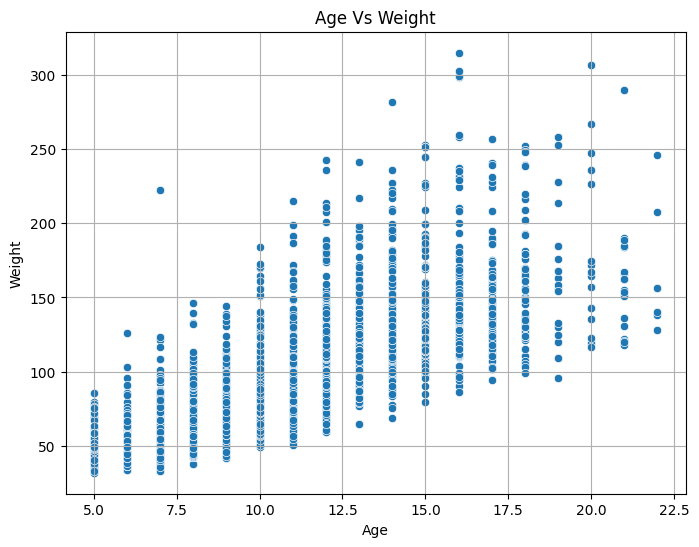

In [23]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Basic_Demos-Age',
    y='Physical-Weight'
)
plt.title('Age Vs Weight')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

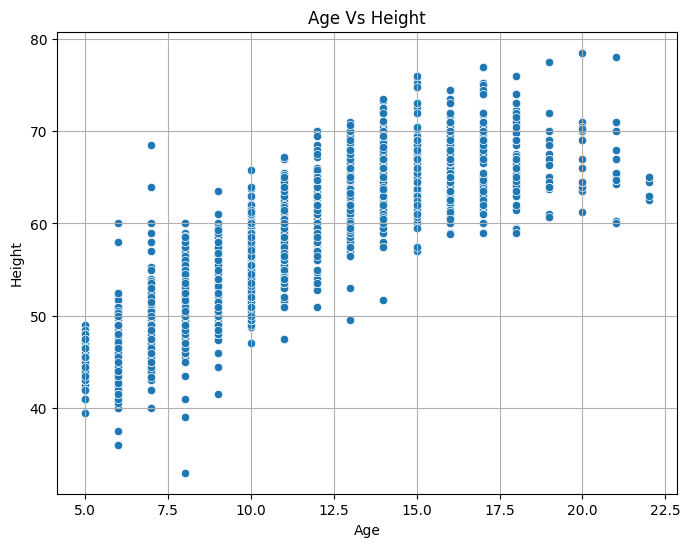

In [24]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Basic_Demos-Age',
    y='Physical-Height'
)
plt.title('Age Vs Height')
plt.xlabel('Age')
plt.ylabel('Height')
plt.grid(True)
plt.show()

In [25]:
train_df['Physical-Height'].min()

33.0

In [26]:
columns = ['Physical-Height', 'Physical-Weight', 'Basic_Demos-Age', 'Basic_Demos-Sex']

# Selecting only these columns for imputation
train_subset = train_df[columns]
test_subset = test_df[columns]

# 2. Creating and fittinf the imputer ONLY on training data
imputer = KNNImputer(n_neighbors=3)
imputer.fit(train_subset)   # <-- fit only on train!

# 3. Transforming both train and test
train_imputed = pd.DataFrame(imputer.transform(train_subset), columns=columns)
test_imputed = pd.DataFrame(imputer.transform(test_subset), columns=columns)

# 4. Replacing the imputed columns in original dataframes
column_replace = ['Physical-Height', 'Physical-Weight']
for col in column_replace:
    train_df[col] = train_imputed[col]
    test_df[col] = test_imputed[col]

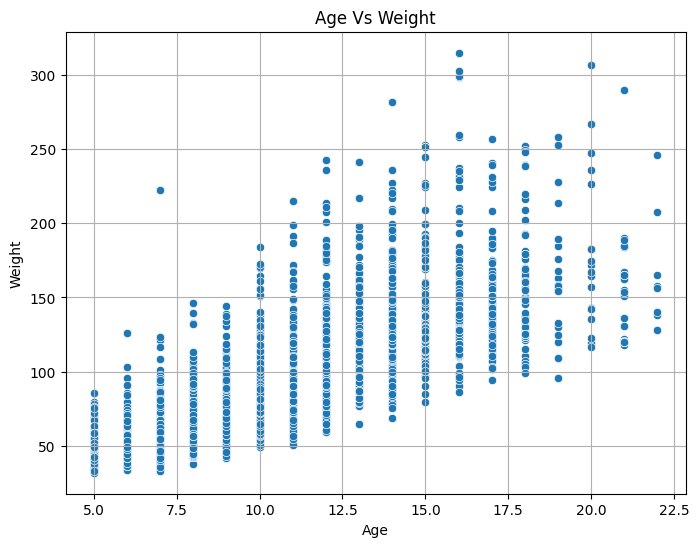

In [27]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Basic_Demos-Age',
    y='Physical-Weight'
)
plt.title('Age Vs Weight')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

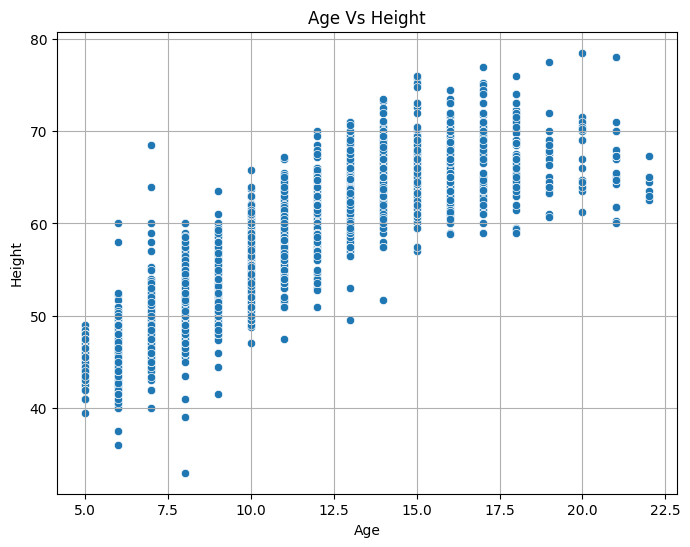

In [28]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Basic_Demos-Age',
    y='Physical-Height'
)
plt.title('Age Vs Height')
plt.xlabel('Age')
plt.ylabel('Height')
plt.grid(True)
plt.show()

### Imputing BMI using Height and Weight

In [29]:
train_df['Physical-Weight'] = train_df['Physical-Weight'] * 0.453592
train_df['Physical-Height'] = train_df['Physical-Height'] * 0.0254

test_df['Physical-Weight'] = test_df['Physical-Weight'] * 0.453592
test_df['Physical-Height'] = test_df['Physical-Height'] * 0.0254

In [30]:
def recompute_bmi(df):
    mask = df['Physical-Weight'].notna() & df['Physical-Height'].notna()
    df['Physical-BMI'] = np.nan
    df.loc[mask, 'Physical-BMI'] = df.loc[mask, 'Physical-Weight'] / (df.loc[mask, 'Physical-Height'] ** 2)
    return df

# Apply to both
train_df = recompute_bmi(train_df)
test_df = recompute_bmi(test_df)

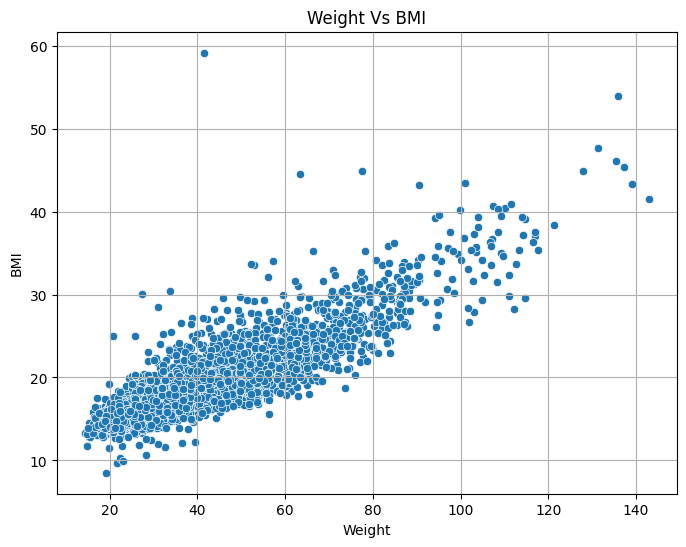

In [31]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Physical-Weight',
    y='Physical-BMI'
)
plt.title('Weight Vs BMI')
plt.xlabel('Weight')
plt.ylabel('BMI')
plt.grid(True)
plt.show()

In [32]:
train_df = train_df.drop(columns=['BIA-BIA_BMI'])

#### Impute waist circumference using linear regression

In [33]:
# 1. Getting all columns with missing values
missing_cols = train_df.columns[train_df.isna().any()]

# 2. Gettinf the correlation matrix (numeric columns only)
corr_matrix = train_df.corr(numeric_only=True)

# 3. Defining our target columns
target_cols = ['Physical-Waist_Circumference']

# 4. Finding non-missing columns
non_missing_cols = [col for col in train_df.columns if col not in missing_cols]

# 5. For each target, gettinf sorted correlations with non-missing columns
for target in target_cols:
    print(f"\nTop correlated non-missing columns with {target}:\n")
    if target not in corr_matrix:
        print("No correlation available (likely too many NaNs).")
        continue
    correlations = corr_matrix[target].dropna()
    correlations = correlations[correlations.index.isin(non_missing_cols) & (correlations.index != target)]
    print(f"Found {len(correlations)} valid correlations")
    print(correlations.sort_values(ascending=False).head(10))


Top correlated non-missing columns with Physical-Waist_Circumference:

Found 6 valid correlations
Physical-Weight    0.915839
Physical-BMI       0.891014
Physical-Height    0.688211
Basic_Demos-Age    0.609601
age_group          0.562547
Basic_Demos-Sex   -0.020013
Name: Physical-Waist_Circumference, dtype: float64


In [34]:
columns = ['Physical-Weight', 'Physical-BMI', 'Physical-Waist_Circumference']
columns_to_impute = ['Physical-Waist_Circumference']

def iterative_impute(train_df, test_df, columns):
    subset_train = train_df[columns]
    subset_test = test_df[columns]
    imputer = IterativeImputer(estimator=BayesianRidge())
    imputer.fit(subset_train)
    train_imputed = pd.DataFrame(imputer.transform(subset_train), columns=columns)
    test_imputed = pd.DataFrame(imputer.transform(subset_test), columns=columns)
    for col in columns_to_impute:
        train_df[col] = train_imputed[col]
        test_df[col] = test_imputed[col]
    return train_df, test_df

# Usage:
train_df, test_df = iterative_impute(train_df, test_df, columns)

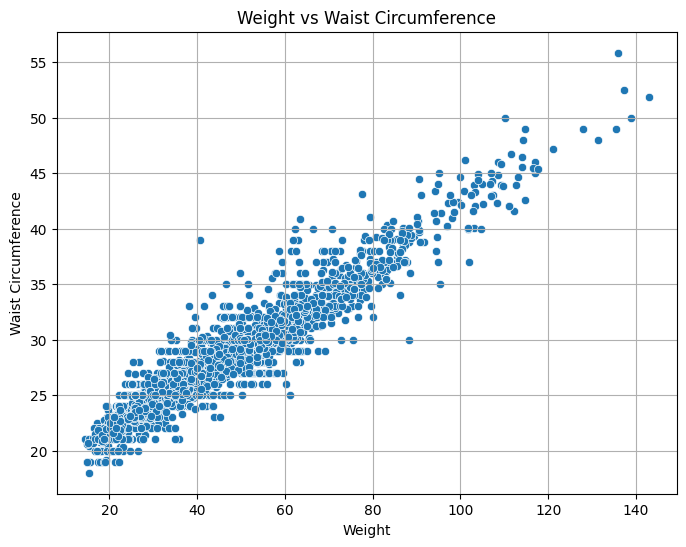

In [35]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Physical-Weight',
    y='Physical-Waist_Circumference'
)
plt.title('Weight vs Waist Circumference')
plt.xlabel('Weight')
plt.ylabel('Waist Circumference')
plt.grid(True)
plt.show()

In [36]:
train_df['Physical-Waist_Circumference'].isna().sum()

0

#### Imputing SDS-Total-Raw using KNN Imputation

In [37]:
equal_mask = train_df['SDS-SDS_Total_T'] == train_df['SDS-SDS_Total_Raw']
print(f"{equal_mask.sum()} records have equal values.")

0 records have equal values.


In [38]:
train_df['SDS_Diff'] = train_df['SDS-SDS_Total_T'] - train_df['SDS-SDS_Total_Raw']
train_df['SDS_Diff']

0        NaN
1       18.0
2       16.0
3       14.0
4        NaN
5       16.0
6       13.0
7        NaN
8        NaN
9        NaN
10       NaN
11      17.0
12      14.0
13       NaN
14       NaN
15      15.0
16      16.0
17       NaN
18      16.0
19       NaN
20      13.0
21       NaN
22      20.0
23      19.0
24      15.0
25      13.0
26       NaN
27      16.0
28      15.0
29       NaN
30       NaN
31      13.0
32      24.0
33       NaN
34       NaN
35       NaN
36      16.0
37       NaN
38      25.0
39       NaN
40      19.0
41      19.0
42       NaN
43       NaN
44      14.0
45      15.0
46      17.0
47       NaN
48      14.0
49      16.0
50      17.0
51      18.0
52      15.0
53      15.0
54      13.0
55      16.0
56      20.0
57      19.0
58      14.0
59       NaN
60      15.0
61      17.0
62      19.0
63      15.0
64      19.0
65       NaN
66      19.0
67       NaN
68       NaN
69       NaN
70      15.0
71       NaN
72      14.0
73       NaN
74       NaN
75      14.0
76       NaN

In [39]:
train_df.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,PAQ_Total,age_group,SDS_Diff
count,3960.000000,3960.000000,2420.000000,3960.000000,3960.000000,3960.000000,3960.000000,2954.000000,2967.000000,2954.000000,...,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000,2195.000000,3960.000000,2606.000000
mean,10.433586,0.372727,65.069008,19.570778,1.424915,41.685607,27.155470,69.648951,81.597236,116.983074,...,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409,2.500820,1.522475,16.685342
std,3.574648,0.483591,11.787310,4.580872,0.187490,18.641519,4.683109,13.611226,13.665196,17.061225,...,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122,0.816259,0.781512,2.958185
min,5.000000,0.000000,25.000000,8.523273,0.838200,14.424226,18.000000,0.000000,27.000000,0.000000,...,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000,0.580000,0.000000,4.000000
25%,8.000000,0.000000,59.000000,16.425001,1.295400,28.031986,23.983409,61.000000,72.000000,107.000000,...,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000,0.000000,1.880000,1.000000,14.000000
50%,10.000000,0.000000,65.000000,18.679585,1.404620,36.196642,26.000000,68.000000,81.000000,114.000000,...,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000,0.000000,2.460000,1.000000,16.000000
75%,13.000000,1.000000,75.000000,21.586521,1.574800,53.523856,29.623670,76.000000,90.500000,125.000000,...,2.000000,1.000000,41.000000,46.000000,64.000000,2.000000,1.000000,3.090000,2.000000,18.000000
max,22.000000,1.000000,95.000000,59.137852,1.993900,142.881480,55.847379,179.000000,138.000000,203.000000,...,5.000000,5.000000,93.000000,96.000000,100.000000,3.000000,3.000000,4.790000,4.000000,26.000000


In [40]:
train_df = train_df.drop(columns=['SDS_Diff'])

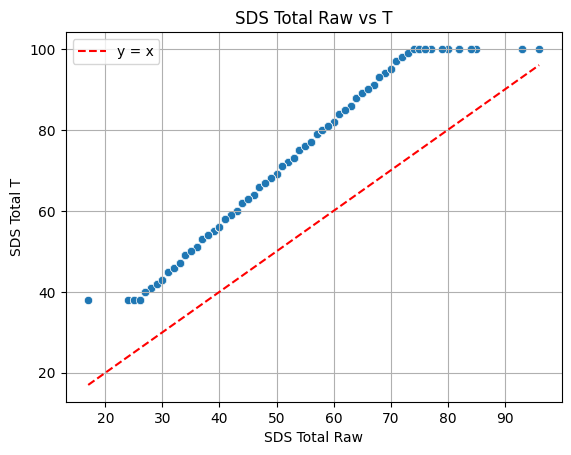

In [41]:
sns.scatterplot(
    x='SDS-SDS_Total_Raw',
    y='SDS-SDS_Total_T',
    data=train_df
)
plt.plot([train_df['SDS-SDS_Total_Raw'].min(), train_df['SDS-SDS_Total_Raw'].max()],
         [train_df['SDS-SDS_Total_Raw'].min(), train_df['SDS-SDS_Total_Raw'].max()],
         color='red', linestyle='--', label='y = x')
plt.legend()
plt.title('SDS Total Raw vs T')
plt.xlabel('SDS Total Raw')
plt.ylabel('SDS Total T')
plt.grid(True)
plt.show()

C:\Users\Daniel Li\AppData\Local\Temp\ipykernel_26924\669775325.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


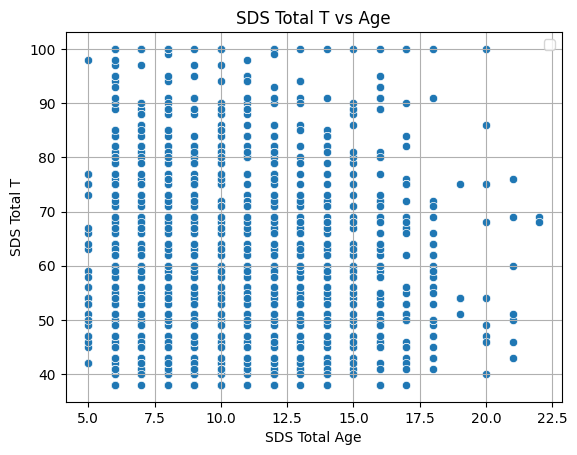

In [42]:
sns.scatterplot(
    x='Basic_Demos-Age',
    y='SDS-SDS_Total_T',
    data=train_df
)

plt.legend()
plt.title('SDS Total T vs Age')
plt.xlabel('SDS Total Age')
plt.ylabel('SDS Total T')
plt.grid(True)
plt.show()

C:\Users\Daniel Li\AppData\Local\Temp\ipykernel_26924\3724607657.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


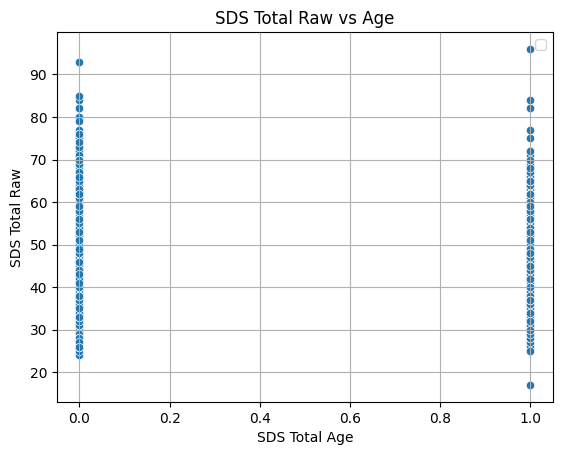

In [43]:
sns.scatterplot(
    x='Basic_Demos-Sex',
    y='SDS-SDS_Total_Raw',
    data=train_df
)

plt.legend()
plt.title('SDS Total Raw vs Age')
plt.xlabel('SDS Total Age')
plt.ylabel('SDS Total Raw')
plt.grid(True)
plt.show()

In [44]:
train_df = train_df.drop(columns=['SDS-SDS_Total_T'])

In [45]:
# 1. Getting all columns with missing values
missing_cols = train_df.columns[train_df.isna().any()]

# 2. Getting the correlation matrix (numeric columns only)
corr_matrix = train_df.corr(numeric_only=True)

# 3. Defining your target columns
target_cols = ['SDS-SDS_Total_Raw']

# 4. Finding non-missing columns
non_missing_cols = [col for col in train_df.columns if col not in missing_cols]

# 5. For each target, getting sorted correlations with non-missing columns
for target in target_cols:
    print(f"\nTop correlated non-missing columns with {target}:\n")
    if target not in corr_matrix:
        print("No correlation available (likely too many NaNs).")
        continue
    correlations = corr_matrix[target].dropna()
    correlations = correlations[correlations.index.isin(non_missing_cols) & (correlations.index != target)]
    print(f"Found {len(correlations)} valid correlations")
    print(correlations.sort_values(ascending=False).head(10))


Top correlated non-missing columns with SDS-SDS_Total_Raw:

Found 7 valid correlations
Physical-BMI                    0.097060
Physical-Waist_Circumference    0.094212
Physical-Weight                 0.088988
Physical-Height                 0.045744
age_group                       0.041960
Basic_Demos-Age                 0.037317
Basic_Demos-Sex                -0.020122
Name: SDS-SDS_Total_Raw, dtype: float64


In [46]:
# Columns we want to impute
columns = ['SDS-SDS_Total_Raw', 'Basic_Demos-Age', 'Basic_Demos-Sex']
columns_to_impute = ['SDS-SDS_Total_Raw']
# 1. Selecting the subset from train and test
train_subset = train_df[columns]
test_subset = test_df[columns]

# 2. Creating and fitting the imputer ONLY on training data
imputer = KNNImputer(n_neighbors=3)
imputer.fit(train_subset)   # <-- fitting only on train!

# 3. Transforming both train and test
train_imputed = pd.DataFrame(imputer.transform(train_subset), columns=columns)
test_imputed = pd.DataFrame(imputer.transform(test_subset), columns=columns)

# 4. Replacing the imputed columns in original dataframes
for col in columns_to_impute:
    train_df[col] = train_imputed[col]
    test_df[col] = test_imputed[col]

C:\Users\Daniel Li\AppData\Local\Temp\ipykernel_26924\4184314625.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


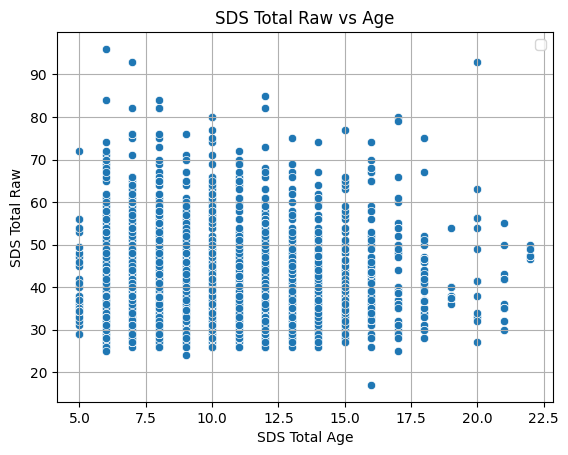

In [47]:
sns.scatterplot(
    x='Basic_Demos-Age',
    y='SDS-SDS_Total_Raw',
    data=train_df
)

plt.legend()
plt.title('SDS Total Raw vs Age')
plt.xlabel('SDS Total Age')
plt.ylabel('SDS Total Raw')
plt.grid(True)
plt.show()

#### Imputing Internet Hours

In [48]:
#quick function for summary data for post and pre imputation
def summarize_data(df, selected_columns=None):
    # Convert single column name to list
    if isinstance(selected_columns, str):
        selected_columns = [selected_columns]
    
    # Use all columns if none specified
    if selected_columns is None:
        selected_columns = df.columns.tolist()
    
    result_tables = []
    
    for column in selected_columns:
        # Get the data for the current column
        col_data = df[column]
        
        # Handle categorical or text data
        if col_data.dtype in ['object', 'category']:
            # Calculate frequencies and percentages
            freq_table = pd.DataFrame()
            values = col_data.value_counts(dropna=False)
            percentages = col_data.value_counts(dropna=False, normalize=True) * 100
            
            # Combine counts and percentages
            freq_table['count (%)'] = [
                f"{count} ({percentage:.2f}%)" 
                for count, percentage in zip(values, percentages)
            ]
            
            result_tables.append(freq_table)
        
        # Handle numerical data
        else:
            # Get descriptive statistics
            num_stats = pd.DataFrame()
            
            # Add basic statistics as a row
            descriptives = col_data.describe().to_dict()
            num_stats = pd.DataFrame(descriptives, index=[0])
            
            # Add missing values count
            num_stats['missing'] = col_data.isna().sum()
            
            # Set index name
            num_stats.index = [column]
            
            result_tables.append(num_stats)
    
    # Combine all results
    combined_stats = pd.concat(result_tables)
    
    return combined_stats

In [49]:
summarize_data(train_df, ['PreInt_EduHx-computerinternet_hoursday'])

,count,mean,std,min,25%,50%,75%,max,missing
PreInt_EduHx-computerinternet_hoursday,3301.0,1.060588,1.094875,0.0,0.0,1.0,2.0,3.0,659


In [50]:
internet_data_age = train_df[train_df['PreInt_EduHx-computerinternet_hoursday'].notna()]
age_range = internet_data_age['Basic_Demos-Age']
print(
    f"Range of Age for those who have internet usage data calculated/already exisiting within our initial data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Range of Age for those who have internet usage data calculated/already exisiting within our initial data: 5 - 22 years


C:\Users\Daniel Li\AppData\Local\Temp\ipykernel_26924\77119067.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45)


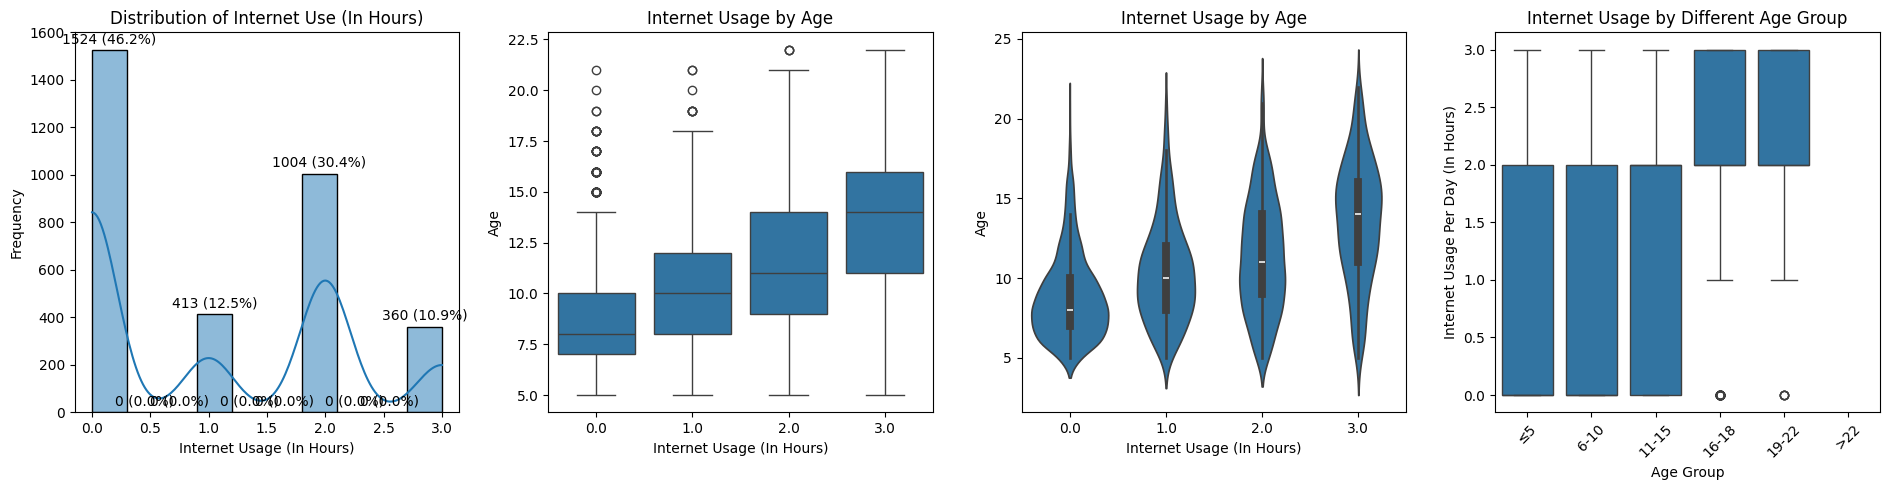

In [51]:
fig, axes = plt.subplots(1, 4, figsize=(19, 5))
ax = axes.ravel()

# Internet usage hours distribution
sns.histplot(data=train_df, x='PreInt_EduHx-computerinternet_hoursday', ax=ax[0], bins=10, kde=True)
ax[0].set_title('Distribution of Internet Use (In Hours)')
ax[0].set_xlabel('Internet Usage (In Hours)')
ax[0].set_ylabel('Frequency')
train_beforeimpute = train_df.copy()
train_internet = train_df.copy()
# Add count and percentage labels to the histogram
total = len(train_internet['PreInt_EduHx-computerinternet_hoursday'].dropna())
for i, p in enumerate(ax[0].patches):
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    ax[0].annotate(f'{count} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                 textcoords='offset points')

# Internet usage by Age (boxplot)
sns.boxplot(data=train_df, x='PreInt_EduHx-computerinternet_hoursday', y='Basic_Demos-Age', ax=ax[1])
ax[1].set_title('Internet Usage by Age')
ax[1].set_ylabel('Age')
ax[1].set_xlabel('Internet Usage (In Hours)')

# Internet usage by Age (violin plot)
sns.violinplot(data=train_df, x='PreInt_EduHx-computerinternet_hoursday', y='Basic_Demos-Age', ax=ax[2])
ax[2].set_title('Internet Usage by Age')
ax[2].set_ylabel('Age')
ax[2].set_xlabel('Internet Usage (In Hours)')

# Create age group labels based on the thresholds from your assign_groups function
thresholds = [5, 10, 15, 18, 22]
age_group_labels = [f"≤{thresholds[0]}", 
                    f"{thresholds[0]+1}-{thresholds[1]}", 
                    f"{thresholds[1]+1}-{thresholds[2]}", 
                    f"{thresholds[2]+1}-{thresholds[3]}", 
                    f"{thresholds[3]+1}-{thresholds[4]}", 
                    f">{thresholds[4]}"]

# Map numeric age_group to labels
train_df['age_group_label'] = train_df['age_group'].map(
    {i: label for i, label in enumerate(age_group_labels)}
)

# Internet usage by Age Group (boxplot)
sns.boxplot(data=train_df, x='age_group_label', y='PreInt_EduHx-computerinternet_hoursday', ax=ax[3], 
            order=age_group_labels)
ax[3].set_title('Internet Usage by Different Age Group')
ax[3].set_ylabel('Internet Usage Per Day (In Hours)')
ax[3].set_xlabel('Age Group')
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

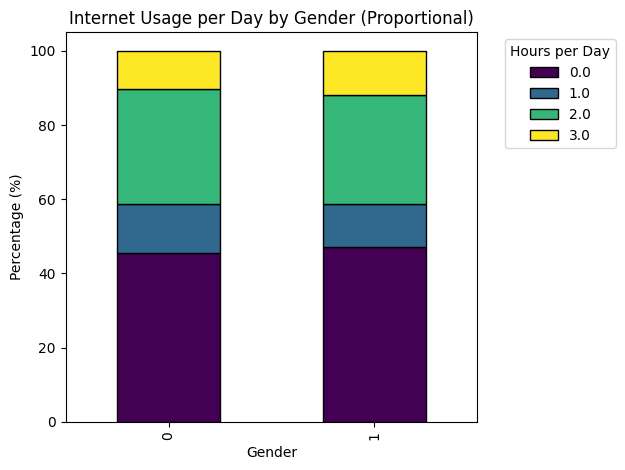

In [52]:
# Recreate proportion stats for plotting
stats_raw = train_df.groupby(['Basic_Demos-Sex', 'PreInt_EduHx-computerinternet_hoursday']).size().unstack(fill_value=0)
stats_prop = stats_raw.div(stats_raw.sum(axis=1), axis=0) * 100

# Plot: Stacked Bar Chart
plt.figure(figsize=(10, 6))
stats_prop.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black')

plt.title("Internet Usage per Day by Gender (Proportional)")
plt.xlabel("Gender")
plt.ylabel("Percentage (%)")
plt.legend(title="Hours per Day", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [53]:
# SDS-SDS_Total_Raw'
# Define predictor columns (excluding 'Season') and the target variable
internet_hours_impute_features = ['Basic_Demos-Age', 'Basic_Demos-Sex', 'SDS-SDS_Total_Raw']
target_column = 'PreInt_EduHx-computerinternet_hoursday'

# Check for missing values in the features
missing_summary = train_df[internet_hours_impute_features].isna().sum()

# Filter and print only the columns with missing values
missing_columns = missing_summary[missing_summary > 0]
print("Columns with NaN values in training features:")
print(missing_columns)

missing_count = train_df[target_column].isna().sum()
print(f"Missing values in target column '{target_column}': {missing_count}")

# Select rows with known target values for training
training_subset = train_df[train_df[target_column].notna()]
X_train_data = training_subset[internet_hours_impute_features]
y_train_data = training_subset[target_column]

# Define a transformer pipeline for preprocessing
transform_pipeline = ColumnTransformer(
    transformers=[
        ('numeric', 'passthrough', internet_hours_impute_features)
    ]
)

# Combine preprocessing with a logistic regression model
prediction_model = Pipeline(steps=[
    ('transform', transform_pipeline),
    ('logistic_model', LogisticRegression(max_iter=1000, multi_class='ovr'))
])

# Train the model using the available data
prediction_model.fit(X_train_data, y_train_data)


train_missing = train_df[train_df[target_column].isna()][internet_hours_impute_features]
print(train_missing.head())
predicted_values = prediction_model.predict(train_missing)

train_df.loc[train_df[target_column].isna(), target_column] = predicted_values


# Predict and update missing values in the test dataset
test_missing = test_df[test_df[target_column].isna()]
test_df.loc[test_df[target_column].isna(), target_column] = prediction_model.predict(test_missing[internet_hours_impute_features])

Columns with NaN values in training features:
Series([], dtype: int64)
Missing values in target column 'PreInt_EduHx-computerinternet_hoursday': 659
    Basic_Demos-Age  Basic_Demos-Sex  SDS-SDS_Total_Raw
4                18                1          36.666667
9                19                1          40.000000
10               11                1          42.666667
13               12                0          38.000000
29                8                0          37.666667


c:\Users\Public\anaconda3\envs\mlai\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [54]:
# Call function to evaluate the updated training data
summarize_data(train_df, [target_column])

,count,mean,std,min,25%,50%,75%,max,missing
PreInt_EduHx-computerinternet_hoursday,3960.0,1.003788,1.083871,0.0,0.0,1.0,2.0,3.0,0


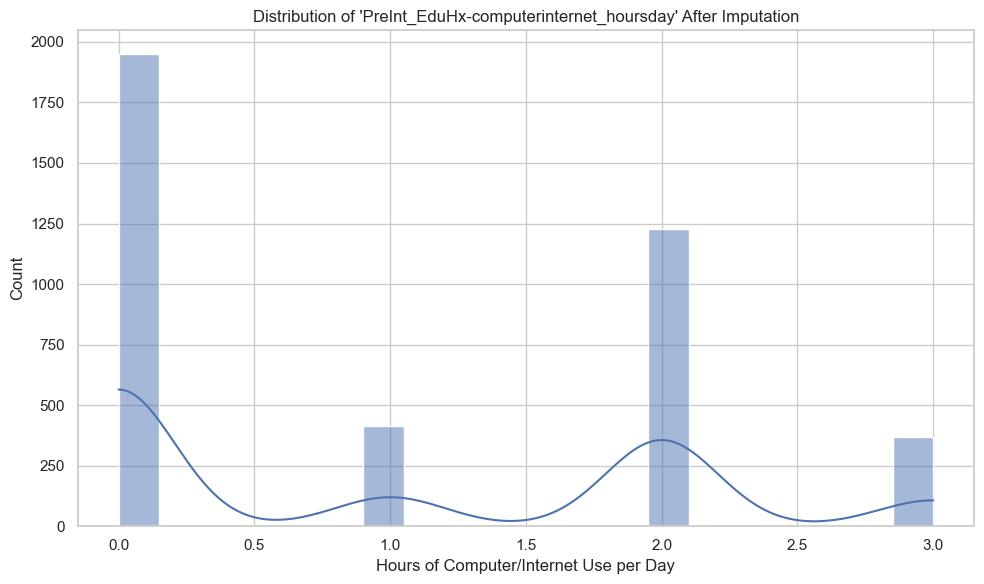

In [55]:
# Set the plot style
sns.set(style="whitegrid")

# Plot the distribution of the target column after imputation
plt.figure(figsize=(10, 6))
sns.histplot(train_df[target_column], bins=20, kde=True)

plt.title(f"Distribution of '{target_column}' After Imputation")
plt.xlabel("Hours of Computer/Internet Use per Day")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [56]:
# Define the features to normalize
features_to_normalize = ['Basic_Demos-Age', 'PreInt_EduHx-computerinternet_hoursday']

# Initialize the scaler
scaler = MinMaxScaler()

# 1. Fit ONLY on train
scaler.fit(train_df[features_to_normalize])

# 2. Transform train
normalized_features_train = scaler.transform(train_df[features_to_normalize])
train_df['norm_age'] = normalized_features_train[:, 0]
train_df['norm_internet_usage'] = normalized_features_train[:, 1]
train_df['norm_age_internet_product'] = train_df['norm_age'] * train_df['norm_internet_usage']

# 3. Transform test (IMPORTANT: only transform, NOT fit again!)
normalized_features_test = scaler.transform(test_df[features_to_normalize])
test_df['norm_age'] = normalized_features_test[:, 0]
test_df['norm_internet_usage'] = normalized_features_test[:, 1]
test_df['norm_age_internet_product'] = test_df['norm_age'] * test_df['norm_internet_usage']

# 4. Drop unwanted columns (if they exist)
for col in ['norm_age', 'norm_internet_usage', 'age_group_label']:
    if col in train_df.columns:
        train_df = train_df.drop(columns=[col])

    if col in test_df.columns:
        test_df = test_df.drop(columns=[col])

# 5. (Optional) Check stats
print("Train stats after normalization:")
print(train_df[['norm_age_internet_product']].describe())

print("\nTest stats after normalization:")
print(test_df[['norm_age_internet_product']].describe())


Train stats after normalization:
       norm_age_internet_product
count                3960.000000
mean                    0.144499
std                     0.200430
min                     0.000000
25%                     0.000000
50%                     0.000000
75%                     0.274510
max                     1.000000

Test stats after normalization:
       norm_age_internet_product
count                  20.000000
mean                    0.163725
std                     0.174020
min                     0.000000
25%                     0.000000
50%                     0.127451
75%                     0.274510
max                     0.549020


# ACTIGRAPHY

In [57]:
def time_features(df):
    # Convert time_of_day to hours
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)
    # Basic features 
    features = [
        df["non-wear_flag"].mean(),
        df["enmo"][df["enmo"] >= 0.05].sum(), # Filters out low level noise
    ]
    
    # Define conditions for night, day, and no mask (full data)
    night = ((df["hours"] >= 21) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 6))
    no_mask = np.ones(len(df), dtype=bool)
    
    # List of columns of interest and masks
    keys = ["enmo", "anglez", "light", "battery_voltage"]
    masks = [no_mask, night, day]
    
    # Helper function for feature extraction
    def extract_stats(data):
        return [
            data.mean(), 
            data.std(), 
            data.max(), 
            data.min(), 
            data.diff().mean(), 
            data.diff().std()
        ]
    
    # Iterate over keys and masks to generate the statistics
    for key in keys:
        for mask in masks:
            filtered_data = df.loc[mask, key]
            features.extend(extract_stats(filtered_data))

    return features

def process_file(filename, dirname):
    # Process file and extract time features
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return time_features(df), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    # Load time series from directory in parallel
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [58]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet'

In [ ]:
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 12.09it/s]


In [ ]:
# Principal Component Analysis
def perform_pca(train, test, n_components=None, random_state=42):
    
    pca = PCA(n_components=n_components, random_state=random_state)
    train_pca = pca.fit_transform(train)
    test_pca = pca.transform(test)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio of the components:\n {explained_variance_ratio}")
    print(np.sum(explained_variance_ratio))
    
    train_pca_df = pd.DataFrame(train_pca, columns=[f'PC_{i+1}' for i in range(train_pca.shape[1])])
    test_pca_df = pd.DataFrame(test_pca, columns=[f'PC_{i+1}' for i in range(test_pca.shape[1])])
    
    return train_pca_df, test_pca_df, pca

In [ ]:
# Processing the time series data and merging with the main dataset
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

scaler = StandardScaler() 
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

for c in df_train.columns:
    m = np.mean(df_train[c])
    df_train[c].fillna(m, inplace=True)
    df_test[c].fillna(m, inplace=True)

print(df_train.shape)

df_train_pca, df_test_pca, pca = perform_pca(df_train, df_test, n_components=15, random_state=SEED)

df_train_pca['id'] = train_ts['id']
df_test_pca['id'] = test_ts['id']

train = pd.merge(train_df, df_train_pca, how="left", on='id')
test = pd.merge(test_df, df_test_pca, how="left", on='id')
train.shape

NameError: name 'train_ts' is not defined

In [59]:
train = train_df
test = test_df

In [60]:
train.to_csv("train_values_merge.csv", index=False)
test.to_csv("test_values_merge.csv", index=False)

In [61]:
# Features to exclude, because they're not in test
exclude = ['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii', 'id']

y_model = "PCIAT-PCIAT_Total" # Score, target for the model
y_comp = "sii" # Index, target of the competition
categorical_features = ['Basic_Demos-Sex','BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday', 
                        'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 
                        'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 
                        'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 
                        'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 
                        'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 
                        'PCIAT-PCIAT_Total', 'sii', 'id']
features = [f for f in train.columns if f not in exclude]
numerical_features = [f for f in train.columns if f not in categorical_features]
categorical_features_pred = ['Basic_Demos-Sex', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday']

In [62]:
train[categorical_features_pred] = train[categorical_features_pred].astype('category')
test[categorical_features_pred] = test[categorical_features_pred].astype('category')

In [63]:
# Identify Categorical & Numerical Columns
categorical_cols = train.select_dtypes(include=['category']).columns
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns

print(f"\n📝 Categorical Columns: {list(categorical_cols)}")
print(f"\n🔢 Numerical Columns: {list(numerical_cols)}")


📝 Categorical Columns: ['Basic_Demos-Sex', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday']

🔢 Numerical Columns: ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCI

In [64]:
## WE ARE USING LASSO ONLY FOR NUMERICAL FEATURES
class Impute_With_Model:
    
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        self.group_means_dict = {} #Stores mean for numerical features and mode for categorical features
        self.group_col = "age_group" # Group column for mean imputation

    '''def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features'''
    
    def find_features(self, data, feature, tmp_features, min_corr=0.4):
        # Step 1: Identify rows where the target feature is missing
        missing_rows = data[feature].isna()

        # Step 2: Exclude tmp_features that are too missing in those rows
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_missingness = np.array(tmp_features)[na_fraction <= self.na_frac]

        # Step 3: Split valid features into numeric and categorical
        numeric_features = [f for f in valid_missingness if pd.api.types.is_numeric_dtype(data[f])]
        categorical_features = [f for f in valid_missingness if not pd.api.types.is_numeric_dtype(data[f])]

        # Step 4: Compute correlation for numeric features only
        if pd.api.types.is_numeric_dtype(data[feature]):
            non_missing_data = data[feature].notna()
            corrs = data.loc[non_missing_data, numeric_features].corrwith(
                data.loc[non_missing_data, feature], numeric_only=True
            )
            valid_numerics = corrs[abs(corrs) >= min_corr].index.tolist()
        else:
            valid_numerics =numeric_features
        # Step 5: Keep numerics with high correlation + all categoricals
        
        valid_features = valid_numerics + categorical_features

        return valid_features



    def fit_models(self, model, data, features, numerical_features):
        self.features = features
        n_data = data.shape[0]
        self.group_means_dict = {}
        for feature in features:
            if pd.api.types.is_float_dtype(data[feature]) or pd.api.types.is_integer_dtype(data[feature]):
                self.group_means_dict[feature] = data.groupby(self.group_col)[feature].mean()
            elif pd.api.types.is_categorical_dtype(data[feature]) or pd.api.types.is_object_dtype(data[feature]):
                self.group_means_dict[feature] = data.groupby(self.group_col)[feature].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

        for feature in features:
            if data[feature].dtype in ['float64', 'int64']:
                self.mean_dict[feature] = np.mean(data[feature])
            elif data[feature].dtype in ['object', 'category']:
                self.mean_dict[feature] = data[feature].mode().iloc[0]
            
        for feature in tqdm(numerical_features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        group_means = self.group_means_dict[f]
                        X[f] = X.apply(
                            lambda row: group_means[row[self.group_col]] if pd.isna(row[f]) else row[f],
                            axis=1
                        )
                        #X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", self.mean_dict[feature])
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            group_means = self.group_means_dict[feature]
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data.loc[missing_rows, feature] = imputed_data.loc[missing_rows].apply(
                        lambda row: group_means.get(row[self.group_col], self.mean_dict[feature]), axis=1
                    )
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data
    
    def impute_test(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            if feature in exclude:
                continue
            group_means = self.group_means_dict[feature]
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data.loc[missing_rows, feature] = imputed_data.loc[missing_rows].apply(
                        lambda row: group_means.get(row[self.group_col], self.mean_dict[feature]), axis=1
                    )
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

In [65]:
model = LassoCV(cv=5, random_state=SEED)
imputer = Impute_With_Model(na_frac=0.4) 
# na_frac is the maximum fraction of missing values until which a feature is imputed with the model
# if there are more missing values than for example 40% then we revert to mean imputation
imputer.fit_models(model, train, features, numerical_features)
train_impute = imputer.impute(train)


C:\Users\Daniel Li\AppData\Local\Temp\ipykernel_26924\2188317156.py:55: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(data[feature]) or pd.api.types.is_object_dtype(data[feature]):
  0%|          | 0/33 [00:00<?, ?it/s]

100%|██████████| 33/33 [00:04<00:00,  8.17it/s]


In [66]:
## WE ARE USING LASSO ONLY FOR NUMERICAL FEATURES
class Impute_With_Model_lr:
    
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        self.group_means_dict = {} #Stores mean for numerical features and mode for categorical features
        self.group_col = "age_group" # Group column for mean imputation

    '''def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features'''
    
    def find_features(self, data, feature, tmp_features, min_corr=0.4):
        # Step 1: Identify rows where the target feature is missing
        missing_rows = data[feature].isna()

        # Step 2: Exclude tmp_features that are too missing in those rows
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_missingness = np.array(tmp_features)[na_fraction <= self.na_frac]

        # Step 3: Split valid features into numeric and categorical
        numeric_features = [f for f in valid_missingness if pd.api.types.is_numeric_dtype(data[f])]
        categorical_features = [f for f in valid_missingness if not pd.api.types.is_numeric_dtype(data[f])]

        # Step 4: Compute correlation for numeric features only
        if pd.api.types.is_numeric_dtype(data[feature]):
            non_missing_data = data[feature].notna()
            corrs = data.loc[non_missing_data, numeric_features].corrwith(
                data.loc[non_missing_data, feature], numeric_only=True
            )
            valid_numerics = corrs[abs(corrs) >= min_corr].index.tolist()
        else:
            valid_numerics =numeric_features
        # Step 5: Keep numerics with high correlation + all categoricals
        
        valid_features = valid_numerics + categorical_features

        return valid_features



    def fit_models(self, model, data, features, categorical_features):
        self.features = features
        n_data = data.shape[0]
        self.group_means_dict = {}
        for feature in features:
            if pd.api.types.is_float_dtype(data[feature]) or pd.api.types.is_integer_dtype(data[feature]):
                self.group_means_dict[feature] = data.groupby(self.group_col)[feature].mean()
            elif pd.api.types.is_categorical_dtype(data[feature]) or pd.api.types.is_object_dtype(data[feature]):
                self.group_means_dict[feature] = data.groupby(self.group_col)[feature].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

        for feature in features:
            if data[feature].dtype in ['float64', 'int64']:
                self.mean_dict[feature] = np.mean(data[feature])
            elif data[feature].dtype in ['object', 'category']:
                self.mean_dict[feature] = data[feature].mode().iloc[0]
            
        for feature in tqdm(categorical_features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        group_means = self.group_means_dict[f]
                        X[f] = X.apply(
                            lambda row: group_means[row[self.group_col]] if pd.isna(row[f]) else row[f],
                            axis=1
                        )
                        #X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", self.mean_dict[feature])
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            group_means = self.group_means_dict[feature]
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data.loc[missing_rows, feature] = imputed_data.loc[missing_rows].apply(
                        lambda row: group_means.get(row[self.group_col], self.mean_dict[feature]), axis=1
                    )
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    predicted = model[0].predict(X_missing[model[1]])

                    # If feature is categorical and has categories defined, convert to object before assignment
                    if pd.api.types.is_categorical_dtype(imputed_data[feature]):
                        imputed_data[feature] = imputed_data[feature].astype(object)

                    imputed_data.loc[missing_rows, feature] = predicted
        return imputed_data
    
    def impute_test(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            if feature in exclude:
                continue
            group_means = self.group_means_dict[feature]
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data.loc[missing_rows, feature] = imputed_data.loc[missing_rows].apply(
                        lambda row: group_means.get(row[self.group_col], self.mean_dict[feature]), axis=1
                    )
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    predicted = model[0].predict(X_missing[model[1]])

                    # If feature is categorical and has categories defined, convert to object before assignment
                    if pd.api.types.is_categorical_dtype(imputed_data[feature]):
                        imputed_data[feature] = imputed_data[feature].astype(object)

                    imputed_data.loc[missing_rows, feature] = predicted
        return imputed_data

In [67]:
model_lr = LogisticRegression(max_iter=200, solver='lbfgs', multi_class='auto')
imputer_lr = Impute_With_Model_lr(na_frac=0.4) 
# na_frac is the maximum fraction of missing values until which a feature is imputed with the model
# if there are more missing values than for example 40% then we revert to mean imputation
imputer_lr.fit_models(model_lr, train_impute, features, categorical_features_pred)
train_impute_lr = imputer_lr.impute(train_impute)


C:\Users\Daniel Li\AppData\Local\Temp\ipykernel_26924\3305196492.py:55: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(data[feature]) or pd.api.types.is_object_dtype(data[feature]):
  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\Public\anaconda3\envs\mlai\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Public\anaconda3\envs\mlai\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please

In [69]:
test_impute = imputer.impute_test(test)
test_impute_lr = imputer_lr.impute_test(test_impute)

C:\Users\Daniel Li\AppData\Local\Temp\ipykernel_26924\3305196492.py:127: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(imputed_data[feature]):
C:\Users\Daniel Li\AppData\Local\Temp\ipykernel_26924\3305196492.py:127: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(imputed_data[feature]):


In [70]:
train_impute_lr.to_csv("train_values_impute.csv", index=False)
test_impute_lr.to_csv("test_values_impute.csv", index=False)

In [71]:
# Loading the datasets
train_file_path = "train_values_impute.csv"
train_df = pd.read_csv(train_file_path)
test_file_path = "test_values_impute.csv"
test_df = pd.read_csv(test_file_path)
df = train_df

In [72]:
train_ft = train_df.copy()
test_ft = test_df.copy()

In [73]:
def create_new_max_min_col(df):
    df['GS_max'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].max(axis=1)
    df['GS_min'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].min(axis=1)

    df["SR_min"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].min(axis=1)
    df["SR_max"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].max(axis=1)

In [74]:
create_new_max_min_col(train_ft)

In [75]:
create_new_max_min_col(test_ft)

In [76]:
thresholds = [5, 10, 15, 18, 22]
cu_map = {}
pu_map = {}
tl_map = {}
gs_max_map = {}
gs_min_map = {}
bmr_map = {}
dee_map = {}
sr_min_map = {}
sr_max_map = {}
ffmi_map = {}


prev = 0
for i in range(len(thresholds)):
    curr = thresholds[i]
    mean_cu = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['FGC-FGC_CU'].mean()
    mean_pu = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['FGC-FGC_PU'].mean()
    mean_tl = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['FGC-FGC_TL'].mean()
    mean_gs_max = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['GS_max'].mean()
    mean_gs_min = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['GS_min'].mean()
    mean_bmr = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['BIA-BIA_BMR'].mean()
    mean_dee = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['BIA-BIA_DEE'].mean()
    mean_sr_min = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['SR_min'].mean()
    mean_sr_max = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['SR_max'].mean()
    mean_ffmi = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['BIA-BIA_FFMI'].mean()
    cu_map[i] = mean_cu
    pu_map[i] = mean_pu
    tl_map[i] = mean_tl
    gs_max_map[i] = mean_gs_max
    gs_min_map[i] = mean_gs_min
    bmr_map[i] = mean_bmr
    dee_map[i] = mean_dee
    sr_min_map[i] = mean_sr_min
    sr_max_map[i] = mean_sr_max
    ffmi_map[i] = mean_ffmi
    
    prev = curr

In [77]:
print("cu_map: ", cu_map)
print("pu_map: ", pu_map)
print("tl_map: ", tl_map)
print("gs_max_map", gs_max_map)
print("gs_min_map", gs_min_map)
print("bmr_map", bmr_map)
print("dee_map", dee_map)
print("sr_min_map", sr_min_map)
print("sr_max_map", sr_max_map)
print("ffmi_map", ffmi_map)

cu_map:  {0: 1.4894075826009996, 1: 7.476433412668704, 2: 16.73709242262834, 3: 21.407771986194827, 4: 25.30853654685808}
pu_map:  {0: 1.6124985934130887, 1: 4.5169419747697965, 2: 6.784395686334561, 3: 8.478444895075162, 4: 6.821968965779475}
tl_map:  {0: 8.120492018715137, 1: 8.869554898368646, 2: 9.838626506051705, 3: 9.917901720651995, 4: 9.692428580093807}
gs_max_map {0: 3.9099297688947945, 1: 10.55672195840937, 2: 23.292464861164753, 3: 32.78846762533555, 4: 38.36685722870873}
gs_min_map {0: 2.736800716173679, 1: 10.002960767347604, 2: 21.30362495880886, 3: 29.72703462536007, 4: 35.603563385045724}
bmr_map {0: 923.5225434249359, 1: 1044.0911206823437, 2: 1349.4340136900846, 3: 1570.3551673344439, 4: 1600.771724721695}
dee_map {0: 1482.2122961876526, 1: 1727.4929346670197, 2: 2287.1209353919116, 3: 2659.7318780880146, 4: 2689.29223414726}
sr_min_map {0: 9.096963629930148, 1: 8.625937676320195, 2: 8.155678517119915, 3: 8.436815249729667, 4: 8.8197600575827}
sr_max_map {0: 9.8755717

In [78]:
def bin_data(train, test, columns, n_bins=10):
    # Combine train and test for consistent bin edges
    combined = pd.concat([train, test], axis=0)

    bin_edges = {}
    for col in columns:
        # Compute quantile bin edges correctly
        edges = pd.qcut(combined[col], n_bins, retbins=True, labels=False, duplicates="drop")[1]
        bin_edges[col] = edges

    # Apply the same bin edges to both train and test
    for col, edges in bin_edges.items():
        num_bins = len(edges) - 1  # Ensure the correct number of labels
        labels = range(num_bins)   # Matching labels with bins

        train[col] = pd.cut(train[col], bins=edges, labels=labels, include_lowest=True).astype(float)
        test[col] = pd.cut(test[col], bins=edges, labels=labels, include_lowest=True).astype(float)

    return train, test

In [79]:
def feature_engineering(df):

    df["CU_norm"] = df['FGC-FGC_CU'] / df['age_group'].map(cu_map)
    df["PU_norm"] = df['FGC-FGC_PU'] / df['age_group'].map(pu_map)
    df["TL_norm"] = df['FGC-FGC_TL'] / df['age_group'].map(tl_map)

    df['GS_max_norm'] = df['GS_max'] / df["age_group"].map(gs_max_map)
    df['GS_min_norm'] = df['GS_min'] / df["age_group"].map(gs_min_map)

    df['SR_max_norm'] = df['SR_max'] / df["age_group"].map(gs_max_map)
    df['SR_min_norm'] = df['SR_min'] / df["age_group"].map(gs_min_map)

    df["BMR_norm"] = df["BIA-BIA_BMR"] / df["age_group"].map(bmr_map)
    df["DEE_norm"] = df["BIA-BIA_DEE"] / df["age_group"].map(dee_map)

    df["FFMI_norm"] = df["BIA-BIA_FFMI"] / df["age_group"].map(ffmi_map)

    df["ECW_ICW_ratio"] = df["BIA-BIA_ECW"] / df["BIA-BIA_ICW"]

In [80]:
columns_to_bin = [
    "CU_norm", "PU_norm", "TL_norm", "GS_min_norm", "GS_max_norm", 
    "SR_min_norm", "SR_max_norm", "BMR_norm", "DEE_norm", "FFMI_norm", "Physical-HeartRate", "Physical-Waist_Circumference", "Physical-Height" ,"Physical-Weight"
]

In [81]:
# 'BIA-BIA_BMI' already removed, so no need to add here
columns_to_remove = ['FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 
                    'BIA-BIA_FFM', 'BIA-BIA_FMI','BIA-BIA_Frame_num', 'BIA-BIA_LDM']

In [82]:
feature_engineering(train_ft)

In [83]:
feature_engineering(test_ft)

In [84]:
train_ft, test_ft = bin_data(train_ft, test_ft, columns_to_bin, n_bins=10)

In [85]:
train_ft = train_ft.drop(columns_to_remove, axis=1)

In [86]:
test_ft = test_ft.drop(columns_to_remove, axis=1)

In [ ]:
from sklearn.linear_model import LinearRegression

## Helpful Functions
def columns_start_with(df, prefix):
    return [col for col in df.columns if col.startswith(prefix)]

def columns_end_with(df, suffix):
    return [col for col in df.columns if col.endswith(suffix)]


def add(col1, col2, new_col_name=None):
    """
    Add two columns together
    
    Parameters:
    col1, col2 (pd.Series): Columns to add
    new_col_name (str, optional): Name for the new column
    
    Returns:
    pd.Series: Series with addition result
    """
    result = col1 + col2
    if new_col_name is not None:
        result.name = new_col_name
    return result

def subtract(col1, col2, new_col_name=None):
    """
    Subtract col2 from col1
    
    Parameters:
    col1, col2 (pd.Series): Columns for subtraction (col1 - col2)
    new_col_name (str, optional): Name for the new column
    
    Returns:
    pd.Series: Series with subtraction result
    """
    result = col1 - col2
    if new_col_name is not None:
        result.name = new_col_name
    return result

def multiply(col1, col2, new_col_name=None):
    """
    Multiply two columns together
    
    Parameters:
    col1, col2 (pd.Series): Columns to multiply
    new_col_name (str, optional): Name for the new column
    
    Returns:
    pd.Series: Series with multiplication result
    """
    result = col1 * col2
    if new_col_name is not None:
        result.name = new_col_name
    return result

def divide(col1, col2, new_col_name=None, fillna=0):
    """
    Divide col1 by col2
    
    Parameters:
    col1, col2 (pd.Series): Columns for division (col1 / col2)
    new_col_name (str, optional): Name for the new column
    fillna (float, optional): Value to fill NaN results with (from division by zero)
    
    Returns:
    pd.Series: Series with division result
    """
    result = col1 / col2.replace(0, np.nan)
    result = result.fillna(fillna)
    if new_col_name is not None:
        result.name = new_col_name
    return result

def power(col, power_value, new_col_name=None):
    """
    Raise column values to a power
    
    Parameters:
    col (pd.Series): Column to transform
    power_value (float): Power to raise values to
    new_col_name (str, optional): Name for the new column
    
    Returns:
    pd.Series: Series with power result
    """
    result = col ** power_value
    if new_col_name is not None:
        result.name = new_col_name
    return result

def abs_val(col, new_col_name=None):
    """
    Calculate absolute value of a column
    
    Parameters:
    col (pd.Series): Column to transform
    new_col_name (str, optional): Name for the new column
    
    Returns:
    pd.Series: Series with absolute values
    """
    result = col.abs()
    if new_col_name is not None:
        result.name = new_col_name
    return result

def log(col, new_col_name=None, base=np.e, offset=0):
    """
    Calculate log of a column
    
    Parameters:
    col (pd.Series): Column to transform
    new_col_name (str, optional): Name for the new column
    base (float, optional): Log base. Default is natural log (e)
    offset (float, optional): Value to add before taking log (for handling zeros/negatives)
    
    Returns:
    pd.Series: Series with log transformation
    """
    if offset > 0:
        result = np.log(col + offset) / np.log(base)
    else:
        # Handle negative or zero values
        valid_values = col > 0
        result = pd.Series(np.nan, index=col.index)
        result.loc[valid_values] = np.log(col.loc[valid_values]) / np.log(base)
    
    if new_col_name is not None:
        result.name = new_col_name
    return result

def log_diff(col, periods=1, new_col_name=None):
    """
    Calculate log difference (percentage change)
    
    Parameters:
    col (pd.Series): Column to transform
    periods (int, optional): Number of periods to shift for difference
    new_col_name (str, optional): Name for the new column
    
    Returns:
    pd.Series: Series with log difference
    """
    result = np.log(col) - np.log(col.shift(periods))
    if new_col_name is not None:
        result.name = new_col_name
    return result

def sqrt(col, new_col_name=None):
    """
    Calculate square root of a column
    
    Parameters:
    col (pd.Series): Column to transform
    new_col_name (str, optional): Name for the new column
    
    Returns:
    pd.Series: Series with square root values
    """
    # Handle negative values
    result = np.sqrt(col.clip(lower=0))
    if new_col_name is not None:
        result.name = new_col_name
    return result

def rank(col, new_col_name=None, method='average'):
    """
    Calculate the rank of values in a column
    
    Parameters:
    col (pd.Series): Column to transform
    new_col_name (str, optional): Name for the new column
    method (str, optional): Method for rank ties ('average', 'min', 'max', 'first', 'dense')
    
    Returns:
    pd.Series: Series with rank values
    """
    result = col.rank(method=method)
    if new_col_name is not None:
        result.name = new_col_name
    return result

def quantile(col, new_col_name=None, q=4):
    """
    Bin values into quantiles
    
    Parameters:
    col (pd.Series): Column to transform
    new_col_name (str, optional): Name for the new column
    q (int, optional): Number of quantiles. Default is 4 (quartiles)
    
    Returns:
    pd.Series: Series with quantile bins
    """
    result = pd.qcut(col, q=q, labels=False, duplicates='drop')
    if new_col_name is not None:
        result.name = new_col_name
    return result

def normalise(col, new_col_name=None, method='zscore'):
    """
    Normalize a column
    
    Parameters:
    col (pd.Series): Column to transform
    new_col_name (str, optional): Name for the new column
    method (str, optional): Normalization method ('zscore', 'minmax')
    
    Returns:
    pd.Series: Series with normalized values
    """
    if method == 'zscore':
        mean = col.mean()
        std = col.std()
        if std == 0:
            result = pd.Series(0, index=col.index)
        else:
            result = (col - mean) / std
    elif method == 'minmax':
        min_val = col.min()
        max_val = col.max()
        if max_val == min_val:
            result = pd.Series(0, index=col.index)
        else:
            result = (col - min_val) / (max_val - min_val)
    else:
        raise ValueError("Method must be 'zscore' or 'minmax'")
    
    if new_col_name is not None:
        result.name = new_col_name
    return result
def vector_neut(target_col, ref_cols, new_col_name=None):
    """
    Neutralize target column with respect to reference columns using vector projection
    
    Parameters:
    target_col (pd.Series): Target column to neutralize
    ref_cols (list of pd.Series): List of reference columns
    new_col_name (str, optional): Name for the new column
    
    Returns:
    pd.Series: Series with neutralized values
    """
    # Extract target vector and handle scalar values
    if isinstance(target_col, (int, float)):
        return target_col  # Can't neutralize a scalar with respect to vectors
        
    target = target_col.values.copy()  # Make a copy to avoid modifying the original
    
    # Process each reference column individually
    for ref_col in ref_cols:
        # Skip if reference column is a scalar
        if isinstance(ref_col, (int, float)):
            continue
            
        ref_vector = ref_col.values
        
        # Check for division by zero
        denominator = np.sum(ref_vector**2)
        if denominator > 0:
            # Calculate projection and subtract
            projection = np.dot(target, ref_vector) / denominator * ref_vector
            target = target - projection
    
    # Create result Series
    result = pd.Series(target, index=target_col.index)
    if new_col_name is not None:
        result.name = new_col_name
    return result

def regression_neut(target_col, ref_cols, new_col_name=None):
    """
    Neutralize target column with respect to reference columns using linear regression
    
    Parameters:
    target_col (pd.Series): Target column to neutralize
    ref_cols (list of pd.Series): List of reference columns
    new_col_name (str, optional): Name for the new column
    
    Returns:
    pd.Series: Series with neutralized values
    """
    # Handle scalar target
    if isinstance(target_col, (int, float)):
        return target_col  # Can't neutralize a scalar with respect to vectors
    
    # Filter out scalar reference columns
    valid_ref_cols = []
    for ref_col in ref_cols:
        if not isinstance(ref_col, (int, float)):
            valid_ref_cols.append(ref_col)
    
    # If no valid reference columns, return target as is
    if not valid_ref_cols:
        result = target_col.copy()
        if new_col_name is not None:
            result.name = new_col_name
        return result
    
    # Create DataFrame with reference columns
    try:
        ref_df = pd.concat(valid_ref_cols, axis=1)
    except ValueError:
        # Handle case where concat fails (e.g., all Series are empty)
        result = target_col.copy()
        if new_col_name is not None:
            result.name = new_col_name
        return result
    
    # Combine ref_df with target_col for easier handling of missing values
    combined = pd.concat([ref_df, target_col], axis=1)
    
    # Remove rows with NaN values
    valid_data = combined.dropna()
    
    # If no valid rows, return Series with NaNs
    if len(valid_data) == 0:
        result = pd.Series(np.nan, index=target_col.index)
        if new_col_name is not None:
            result.name = new_col_name
        return result
    
    # Extract features and target
    X = valid_data.iloc[:, :-1]
    y = valid_data.iloc[:, -1]
    
    # Fit linear regression
    model = LinearRegression()
    
    # Handle case where X has only one column (reshape required)
    if X.shape[1] == 1:
        model.fit(X.values.reshape(-1, 1), y)
        
        # Make predictions
        valid_indices = valid_data.index
        X_for_predict = ref_df.loc[valid_indices].values.reshape(-1, 1)
        y_pred = model.predict(X_for_predict)
    else:
        model.fit(X, y)
        
        # Make predictions
        valid_indices = valid_data.index
        X_for_predict = ref_df.loc[valid_indices]
        y_pred = model.predict(X_for_predict)
    
    # Compute residuals
    residuals = target_col.loc[valid_indices] - y_pred
    
    # Initialize result with NaN
    result = pd.Series(np.nan, index=target_col.index)
    
    # Update only valid rows
    result.loc[valid_indices] = residuals
    
    if new_col_name is not None:
        result.name = new_col_name
    return result

def groupby(data, group_col, agg_col, agg_func='mean', new_col_name=None):
    """
    Aggregate a column by groups
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the columns
    group_col (pd.Series or list of pd.Series): Column(s) to group by
    agg_col (pd.Series): Column to aggregate
    agg_func (str or function, optional): Aggregation function ('mean', 'median', 'sum', 'std', etc.)
    new_col_name (str, optional): Name for the new column
    
    Returns:
    pd.Series: Series with aggregated values
    """
    # Create a temporary DataFrame
    if isinstance(group_col, list):
        temp_df = pd.concat(group_col + [agg_col], axis=1)
    else:
        temp_df = pd.concat([group_col, agg_col], axis=1)
    
    # Get column names
    if isinstance(group_col, list):
        group_names = [col.name for col in group_col]
    else:
        group_names = [group_col.name]
    
    # Compute aggregation
    result = temp_df.groupby(group_names)[agg_col.name].transform(agg_func)
    
    if new_col_name is not None:
        result.name = new_col_name
    
    return result

def winsorize(col, std=4, new_col_name=None):
    """
    Winsorize a column to limit extreme values based on standard deviations
    
    Parameters:
    col (pd.Series): Column to transform
    std (float, optional): Number of standard deviations to use for clipping values
    new_col_name (str, optional): Name for the new column
    
    Returns:
    pd.Series: Series with winsorized values
    """
    mean = col.mean()
    std_dev = col.std()
    lower_limit = mean - std * std_dev
    upper_limit = mean + std * std_dev
    
    result = col.clip(lower=lower_limit, upper=upper_limit)
    
    if new_col_name is not None:
        result.name = new_col_name
    return result

def bucket(col, buckets=None, range=None, new_col_name=None):
    """
    Convert values into bucket indexes
    
    Parameters:
    col (pd.Series): Column to transform
    buckets (str or list, optional): Comma-separated string or list of bucket boundaries
    range (str, optional): Range specified as "start, end, step"
    new_col_name (str, optional): Name for the new column
    
    Returns:
    pd.Series: Series with bucket indexes
    """
    if buckets is not None:
        # Handle string input
        if isinstance(buckets, str):
            buckets = [float(x.strip()) for x in buckets.split(',')]
        
        # Convert to list if it's another iterable
        buckets = list(buckets)
        
        # Ensure buckets are sorted
        buckets.sort()
        
        # Create bucket labels (one fewer than boundaries)
        labels = list(range(len(buckets) - 1))
        
        # Use pandas cut to create buckets
        result = pd.cut(col, bins=buckets, labels=labels, include_lowest=True)
        
        # Convert to integer Series
        result = pd.Series(result.astype('Int64'), index=col.index)
        
    elif range is not None:
        # Parse range string
        range_parts = [float(x.strip()) for x in range.split(',')]
        
        if len(range_parts) != 3:
            raise ValueError("Range should be specified as 'start, end, step'")
            
        start, end, step = range_parts
        
        # Create bucket boundaries
        bucket_boundaries = np.arange(start, end + step/2, step)
        
        # Create bucket labels
        labels = list(range(len(bucket_boundaries) - 1))
        
        # Use pandas cut to create buckets
        result = pd.cut(col, bins=bucket_boundaries, labels=labels, include_lowest=True)
        
        # Convert to integer Series
        result = pd.Series(result.astype('Int64'), index=col.index)
        
    else:
        raise ValueError("Either 'buckets' or 'range' must be specified")
    
    if new_col_name is not None:
        result.name = new_col_name
    return result

def apply_to_train_test(func):
    """
    Decorator to convert a function that operates on a single dataframe
    to one that operates on both train and test dataframes.
    
    Parameters:
    func (callable): A function that takes a single dataframe and returns a transformed dataframe
    
    Returns:
    callable: A function that takes train and test dataframes and returns transformed versions of both
    """
    def wrapper(train_df, test_df):
        # Apply the function to both dataframes
        train_transformed = func(train_df.copy())
        test_transformed = func(test_df.copy())
        
        # Return both transformed dataframes
        return train_transformed, test_transformed
    
    # Update the wrapper's metadata
    wrapper.__name__ = func.__name__
    wrapper.__doc__ = f"Applies {func.__name__} to both train and test dataframes.\n\nOriginal docstring:\n{func.__doc__}"
    
    return wrapper

@apply_to_train_test
def FE_0(df): #RMSE = 0.5736768792180194
    df_num = df.select_dtypes(include=['float64', 'int64'])
    seasons_col = columns_end_with(df, 'Season')

    # Vector Neutralization of Physical with Age and Sex
    for col in columns_start_with(df_num, 'Physical'):
        df[col+"_neut_ageNsex"] = regression_neut(df[col], [df['Basic_Demos-Age'],df['Basic_Demos-Sex']])

    # Deviation of Seasonality
    for season in seasons_col:
        for header in columns_start_with(df_num, season.replace('-Season','')):
            df[header] = regression_neut(df[header], [df[season]])

    # Winsorize to reduce outliers
    for col in df_num.columns:
        df[col] = winsorize(df[col])

    # Create polynomial features
    for col in df_num.columns:
        if col != 'sii':
            df[f'{col}^2'] = power(df[col], 2)
            df[f'{col}^3'] = power(df[col], 3)

    # Drop all seasonality columns
    for season in seasons_col:
        df = df.drop(columns=[season])
    return df
    
@apply_to_train_test
def FE_1(df): # Regression neutralising all columns against significant ones
    # Get only numeric columns to process
    df_num = df.select_dtypes(include=['float64', 'int64'])
    
    significant_cols = ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
    'Physical-BMI', 'Physical-Height', 'Physical-Weight',
    'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
    'Physical-HeartRate', 'Physical-Systolic_BP']
    
    # Filter significant columns to only include numeric ones that exist in df
    significant_cols = [col for col in significant_cols if col in df_num.columns]
    
    seasons_col = columns_end_with(df_num, 'Season')
    initial_columns = set(df_num.columns) - set(seasons_col)

    # Create interaction terms
    for col1 in initial_columns:
        for col2 in significant_cols:
            if col1 != col2:
                df[col1] = regression_neut(df[col1], df[col2])

    for col in df_num.columns:
        df[col] = winsorize(df[col])

    # Create polynomial features
    for col in df_num.columns:
        if col != 'sii':
            df[f'{col}^2'] = power(df[col], 2)
            df[f'{col}^3'] = power(df[col], 3)

    # Drop all seasonality columns
    df = df.drop(set(seasons_col), axis=1)
    
    return df
    
@apply_to_train_test
def FE_2(df):
    df_num = df.select_dtypes(include=['float64', 'int64'])
    # Hypothesis that Physical affects Fitness Endurance and Fitness Endurance affects FGC
    for col1 in columns_start_with(df_num, 'Physical'):
        for col2 in columns_start_with(df_num, 'Fitness_Endurance'):
            df[col1+"_neut_"+col2] = vector_neut(df[col2], df[col1])

    for col1 in columns_start_with(df_num, 'Fitness_Endurance'):
        for col2 in columns_start_with(df_num, 'FGC'):
            df[col1+"_neut_"+col2] = vector_neut(df[col2], df[col1])

    # Vector Neutralization of Physical with Age and Sex
    for col in columns_start_with(df_num, 'Physical'):
        df[col+"_neut_ageNsex"] = vector_neut(df[col], [df['Basic_Demos-Age'],df['Basic_Demos-Sex']])

    # Winsorize to reduce outliers
    for col in df_num.columns:
        df[col+"_winsorize"] = winsorize(df[col])

    # Create polynomial features
    for col in df_num.columns:
        if col != 'sii':
            df[f'{col}^2'] = power(df[col], 2)
            df[f'{col}^3'] = power(df[col], 3)    
    return df

@apply_to_train_test
def FE_3(df): # Regression neutralising all columns RMSE = 0.588786632439714
    df_num = df.select_dtypes(include=['float64', 'int64'])
    seasons_col = columns_end_with(df, 'Season')
    initial_columns = set(df_num.columns) - set(seasons_col)

    # Create interaction terms
    for col1 in initial_columns:
        for col2 in initial_columns:
            if col1 != col2:
                df[f'{col1}_neut_{col2}'] = regression_neut(df[col1], df[col2])

    return df


def FE_A1(train, test, y_train):
    '''
    Simple Autofeat model for regression and classification 
    '''
    from autofeat import AutoFeatRegressor

    afr_model = AutoFeatRegressor()

    train_transformed = afr_model.fit_transform(train, y_train)
    test_transformed = afr_model.transform(test)
    return train_transformed, test_transformed

def FE_A2(train, test, y_train):
    """
    Featuretools for automated feature engineering using 
    Deep Feature Synthesis (DFS) to create complex features.

    Parameters:
    train (pd.DataFrame): Training data
    test (pd.DataFrame): Test data

    Returns:
    tuple: (train_feature_matrix, test_feature_matrix)
    """

    import featuretools as ft

    # Create an EntitySet
    es = ft.EntitySet(id="feature_engineering")

    # Add the training data as an entity
    es = es.add_dataframe(
        dataframe_name="train",
        dataframe=train.reset_index(drop=True),
        index="index",
        make_index=True
    )

    # Add the test data as an entity
    es = es.add_dataframe(
        dataframe_name="test",
        dataframe=test.reset_index(drop=True),
        index="index", 
        make_index=True
    )

    # Define transformation primitives
    trans_primitives = [
        'add_numeric', 
        'subtract_numeric', 
        'multiply_numeric', 
        'divide_numeric',
        'greater_than',
        'less_than',
        'modulo_numeric',
        'percentile',
        'cum_mean',
        'cum_sum'
    ]

    # Apply Deep Feature Synthesis to training data
    train_feature_matrix, feature_defs = ft.dfs(
        entityset=es,
        target_dataframe_name="train",  # Specify the target dataframe name explicitly
        max_depth=2,
        verbose=1,
        ignore_columns={"train": ["sii"]},  # Specify which columns to ignore in which dataframe
        trans_primitives=trans_primitives
    )

    # Apply the same feature definitions to test data
    test_feature_matrix = ft.calculate_feature_matrix(
        features=feature_defs,
        entityset=es,
        dataframes ="test"  # Specify which dataframe to use
    )

    # Remove highly correlated features
    train_feature_matrix = train_feature_matrix.fillna(0)
    test_feature_matrix = test_feature_matrix.fillna(0)

    print(f"Generated {len(train_feature_matrix.columns)} features")

    train_feature_matrix['sii'] = y_train
    return train_feature_matrix, test_feature_matrix

In [ ]:
##ADDED
import warnings
warnings.filterwarnings('ignore')
train_ft, test_ft = FE_1(train_ft, test_ft)

In [89]:
train_ft.shape

(3960, 188)

In [90]:
train_ft.to_csv("train_ft.csv", index=False)
test_ft.to_csv("test_ft.csv", index=False)

In [177]:
# Loading the datasets
train_file_path = "train_ft.csv"
train = pd.read_csv(train_file_path)
test_file_path = "test_ft.csv"
test = pd.read_csv(test_file_path)
df = train

In [178]:
train.dropna(subset=['sii'], how='all', inplace=True)


In [179]:
sii_thresholds = [30, 50, 80, 100] # Thresholds for rating
def get_rating(x): ## Thresholds for rating
    if 0 <= x <= 29:
        return 0
    elif 30 <= x <= 49:
        return 1
    elif 50 <= x <= 79:
        return 2
    else:
        return 3

def quadratic_weighted_kappa(y_true, y_pred): # The Quadric Kappa Evaluation Metric
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def evaluate_predictions(y_true, oof_non_rounded):
    rounded_p = get_rating(oof_non_rounded)
    return -quadratic_weighted_kappa(y_true, rounded_p)

#train_impute_lr['new_sii'] = train_impute_lr['PCIAT_Total_Imputed'].apply(get_rating)

In [180]:
# Standardising features columns of train and test
train_only = set(train.columns) - set(test.columns)
test_only = set(test.columns) - set(train.columns) 

In [181]:
train_model = train

for col in train.columns:
    if train[col].dtype == 'object' or str(train[col].dtype) == 'category':
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col].astype(str))

X = train_model.drop(columns=list(train_only)+ ['id']) ##ADDED
Y = train['PCIAT-PCIAT_Total']

In [ ]:
def optimize_xgb(trial, X, y, eval_metric='rmse'):
    """
    Optuna objective function for XGBoost parameter optimization.
    
    Parameters:
    trial: Optuna trial object
    X: Features DataFrame
    y: Target Series
    eval_metric: Metric to evaluate on
    
    Returns:
    float: Mean cross-validation score (RMSE)
    """
    # Parameter search space definition
    param = {
        'objective': trial.suggest_categorical('objective', ['reg:squarederror', 'reg:tweedie']),
        'tree_method': 'hist',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1.0, log=True),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    # Add tweedie-specific parameters if that objective is selected
    if param['objective'] == 'reg:tweedie':
        param['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1.1, 1.5)
    
    # Cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    # Perform cross-validation
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train model with current parameters
        model = XGBRegressor(**param)
        model.fit(X_train, y_train)
        
        # Evaluate model
        preds = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(score)
    
    # Return mean score across all folds
    return np.mean(scores)


def optimize_lgbm(trial, X, y, eval_metric='rmse'):
    """
    Optuna objective function for LightGBM parameter optimization.
    
    Parameters:
    trial: Optuna trial object
    X: Features DataFrame
    y: Target Series
    eval_metric: Metric to evaluate on
    
    Returns:
    float: Mean cross-validation score (RMSE)
    """
    # Parameter search space definition
    param = {
        'objective': trial.suggest_categorical('objective', ['regression', 'poisson', 'tweedie']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1.0, log=True),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    # Add tweedie-specific parameters if that objective is selected
    if param['objective'] == 'tweedie':
        param['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1.1, 1.7)
    
    # Cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    # Perform cross-validation
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train model with current parameters
        model = LGBMRegressor(**param, verbose=-1)
        model.fit(X_train, y_train)
        
        # Evaluate model
        preds = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(score)
    
    # Return mean score across all folds
    return np.mean(scores)


def optimize_xtraTrees(trial, X, y, eval_metric='rmse'):
    """
    Optuna objective function for ExtraTrees parameter optimization.
    
    Parameters:
    trial: Optuna trial object
    X: Features DataFrame
    y: Target Series
    eval_metric: Metric to evaluate on
    
    Returns:
    float: Mean cross-validation score (RMSE)
    """
    # Parameter search space definition
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': SEED,
    }
    
    # Cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    # Perform cross-validation
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train model with current parameters
        model = ExtraTreesRegressor(**param)
        model.fit(X_train, y_train)
        
        # Evaluate model
        preds = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(score)
    
    # Return mean score across all folds
    return np.mean(scores)

def optimize_catboost(trial, X, y, eval_metric='rmse'):
    """
    Optuna objective function for CatBoost parameter optimization.
    
    Parameters:
    trial: Optuna trial object
    X: Features DataFrame
    y: Target Series
    eval_metric: Metric to evaluate on
    
    Returns:
    float: Mean cross-validation score (RMSE)
    """
    # Parameter search space definition
    param = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'Poisson', 'MAE']),
        'random_seed': 42,
        'verbose': 0
    }
    
    # Cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    # Perform cross-validation
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train model with current parameters
        model = CatBoostRegressor(**param)
        model.fit(X_train, y_train, silent=True)
        
        # Evaluate model
        preds = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(score)
    
    # Return mean score across all folds
    return np.mean(scores)
    

def run_optuna_optimization(X, y, model_type='xgb', n_trials=50):
    """
    Run Optuna optimization for the specified model type.
    
    Parameters:
    X: Features DataFrame
    y: Target Series
    model_type: Type of model to optimize ('xgb', 'lgbm', or 'catboost')
    n_trials: Number of optimization trials
    
    Returns:
    dict: Best parameters found by Optuna
    """
    print(f"Starting optimization for {model_type.upper()} with {n_trials} trials")
    
    # Create Optuna study (set direction to minimize for RMSE)
    study = optuna.create_study(direction='minimize')
    
    # Select the appropriate objective function
    if model_type.lower() == 'xgb':
        objective_function = lambda trial: optimize_xgb(trial, X, y)
    elif model_type.lower() == 'lgbm':
        objective_function = lambda trial: optimize_lgbm(trial, X, y)
    elif model_type.lower() == 'xtratrees':
        objective_function = lambda trial: optimize_xtraTrees(trial, X, y)
    elif model_type.lower() == 'catboost':
        objective_function = lambda trial: optimize_catboost(trial, X, y)
    else:
        raise ValueError("model_type must be 'xgb', 'lgbm', 'catboost' or 'xtratrees'")
    
    # Run the optimization process
    study.optimize(objective_function, n_trials=n_trials)
    
    # Print results
    print(f"Best score: {study.best_value}")
    print(f"Best parameters for {model_type.upper()}:")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")
    
    # Return the best parameters
    return study.best_params

In [ ]:
# For XGBoost
XGB_OPTIMAL_PARAMS = run_optuna_optimization(X, Y, model_type='xgb', n_trials=200)

# For LightGBM
LGBM_OPTIMAL_PARAMS = run_optuna_optimization(X, Y, model_type='lgbm', n_trials=200)

# For CatBoost
CATBOOST_OPTIMAL_PARAMS = run_optuna_optimization(X, Y, model_type='catboost', n_trials=50)

# For ExtraTree
XTRATREE_OPTIMAL_PARAMS = run_optuna_optimization(X, Y, model_type='xtratrees', n_trials=50)

[I 2025-04-11 20:53:35,192] A new study created in memory with name: no-name-1cabe73f-2b9f-402e-b77f-0218d1a6b349


Starting optimization for XGB with 50 trials


[I 2025-04-11 20:53:37,565] Trial 0 finished with value: 17.726060491402595 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 216, 'max_depth': 5, 'learning_rate': 0.05486187709802851, 'subsample': 0.7345702693403646, 'colsample_bytree': 0.639018914745299, 'reg_alpha': 0.16486315971022691, 'reg_lambda': 0.010988280743983413}. Best is trial 0 with value: 17.726060491402595.
[W 2025-04-11 20:53:38,756] Trial 1 failed with parameters: {'objective': 'reg:squarederror', 'n_estimators': 442, 'max_depth': 7, 'learning_rate': 0.04340406631028603, 'subsample': 0.6900972874836769, 'colsample_bytree': 0.6867269595364776, 'reg_alpha': 0.014475976810514449, 'reg_lambda': 0.01175592762947965} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Public\anaconda3\envs\mlai\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Daniel Li\AppData\Local\Temp\ipykernel_2692

KeyboardInterrupt: 

In [184]:
def sample_weights_optimized(series):
    """
    Calculate sample weights for continuous PCIAT target variables using equal-width binning to solve class imbalance issue by finding frequency of each pciat total value: Converts frequency into weight:
    Rare bins get higher weights (inverse of frequency is used to calculate weight )
    Common bins get lower weights

    Parameters:
    series: pandas Series containing all target values (assumed continuous with no nulls)
    
    Returns:
    pandas Series: Sample weights normalized to mean 1.0
    """
    # Handle edge cases efficiently
    if len(series) <= 1 or series.nunique() <= 1:
        return pd.Series(1.0, index=series.index)
    
    # Create equal-width bins directly
    bins = pd.cut(series, bins=10, labels=False)
    
    # Get bin counts and calculate inverse frequency in one step
    bin_counts = bins.value_counts()
    inverse_freq = 1.0 / bin_counts
    
    # Map weights back to samples using the bin indices
    weights = bins.map(inverse_freq)
    
    # Normalize weights to mean 1.0
    return weights / weights.mean()

In [ ]:
# OPTIMIZE_PARAMS
XGB_PARAMS1 = {
  'objective': 'reg:squarederror',
  'n_estimators': 196,
  'max_depth': 3,
  'learning_rate': 0.024377457632555548,
  'subsample': 0.6560522119294856,
  'colsample_bytree': 0.6449303629351186,
  'reg_alpha': 0.11418294928640656,
  'reg_lambda': 0.00020319727244911808
}

XGB_PARAMS2 = {
  'objective': 'reg:squarederror',
  'n_estimators': 133,
  'max_depth': 3,
  'learning_rate': 0.0384152285477552,
  'subsample': 0.7020939643551841,
  'colsample_bytree': 0.6609469012147406,
  'reg_alpha': 0.5331376076945142,
  'reg_lambda': 0.41652705520227296
}

LGB_PARAMS1 = {
  'objective': 'tweedie',
  'n_estimators': 147,
  'max_depth': 3,
  'learning_rate': 0.055966861466691824,
  'subsample': 0.8742933181290675,
  'colsample_bytree': 0.6011125781497625,
  'min_child_samples': 84,
  'reg_alpha': 0.0015728062089088051,
  'reg_lambda': 0.0016424117927587845,
  'tweedie_variance_power': 1.1756487949004444
}

LGB_PARAMS2 = {
  'objective': 'regression',
  'n_estimators': 175,
  'max_depth': 3,
  'learning_rate': 0.03420332404085047,
  'subsample': 0.8140800266287731,
  'colsample_bytree': 0.8031120023830383,
  'min_child_samples': 56,
  'reg_alpha': 0.00011773008122912229,
  'reg_lambda': 0.0047894025248717996
}

XTRATREE_PARAMS1 = {
    'n_estimators': 717,
    'max_depth': 7,
    'min_samples_leaf': 8,
    'bootstrap': True
}

CATBOOST_PARAMS1 = {
    'iterations': 234,
    'depth': 7,
    'learning_rate': 0.028451259607870098,
    'random_strength': 1.0806351908632638e-08,
    'bagging_temperature': 2.501266915274977,
    'l2_leaf_reg': 1.5560922287654877,
    'min_data_in_leaf': 13,
    'loss_function': 'RMSE'
}

In [186]:
def convert_to_categories(predictions, boundary_values):
    """
    Transform continuous prediction values into discrete categories 
    based on specified boundary thresholds.
    """
    categories = np.zeros(len(predictions), dtype=int)
    
    # Apply each threshold sequentially
    for category, threshold in enumerate(boundary_values):
        categories[predictions >= threshold] = category + 1
        
    return categories


def find_optimal_boundaries(actual_values, model_predictions, initial_boundaries=None):
    """
    Determine the optimal category boundaries that maximize agreement
    between predictions and actual values using quadratic weighted kappa.
    """
    # Set default initial boundaries if none provided
    if initial_boundaries is None:
        initial_boundaries = [0.5, 1.5, 2.5]
    
    # Define optimization objective function
    def objective_function(boundaries, actuals, predictions):
        categorized_predictions = convert_to_categories(predictions, boundaries)
        kappa_score = cohen_kappa_score(actuals, categorized_predictions, weights='quadratic')
        # Return negative since we want to maximize kappa
        return -kappa_score
    
    # Perform optimization
    optimization_result = minimize(
        objective_function, 
        x0=initial_boundaries,
        args=(actual_values, model_predictions),
        method='Powell'
    )
    
    # Verify optimization completed successfully
    if not optimization_result.success:
        raise RuntimeError("Boundary optimization failed to converge")
        
    return optimization_result.x

In [187]:
def evaluate_k_fold_validate(estimator, dataset , target_col, class_col, splitter, apply_weighting=False, show_progress=False):
   """
   Evaluates a model using k-fold validation, optimizing decision boundaries to maximize agreement.
   
   Parameters:
   - estimator: Model object with fit and predict methods
   - dataset: DataFrame containing all data
   - predictors: List of feature column names
   - target_col: Column name for continuous target variable
   - class_col: Column name for class labels
   - splitter: Cross-validation iterator
   - apply_weighting: Whether to apply balancing weights during training
   - show_progress: Whether to display progress information
   
   Returns:
   - mean_agreement: Average kappa agreement score across folds
   - holdout_predictions: Predictions for all samples from their respective holdout folds
   - boundary_sets: Optimized decision boundaries from each fold
   """
   agreement_metrics = []
   holdout_predictions = np.zeros(dataset.shape[0])
   boundary_sets = []
   
   # Default decision boundaries if needed
   default_boundaries = sii_thresholds
   
   # Iterate through cross-validation folds
   for fold_num, (training_indices, validation_indices) in enumerate(splitter.split(dataset, dataset[class_col])):
       # Extract training and validation data
       X_training = dataset.iloc[training_indices]
       y_training_target = dataset[target_col].iloc[training_indices]
       y_training_class = dataset[class_col].iloc[training_indices]
       
       X_validation = dataset.iloc[validation_indices]
       y_validation_target = dataset[target_col].iloc[validation_indices]
       y_validation_class = dataset[class_col].iloc[validation_indices]

       # # Remove the 'id' column from your training data
       # X_training = X_training.drop(columns=['id'])
       # X_validation = X_validation.drop(columns=['id'])
       
       # Apply sample weighting if needed for class imbalance issue 
       if apply_weighting:
           sample_weights = sample_weights_optimized(y_training_target)
           estimator.fit(X_training, y_training_target, sample_weight=sample_weights)
       else:
           estimator.fit(X_training, y_training_target)
       
       # Generate predictions
       training_predictions = estimator.predict(X_training)
       validation_predictions = estimator.predict(X_validation)
       
       # Store predictions in the appropriate positions
       holdout_predictions[validation_indices] = validation_predictions
       
       # Optimize decision boundaries based on training predictions
       optimized_boundaries = find_optimal_boundaries(
           y_training_class, 
           training_predictions, 
           initial_boundaries=default_boundaries
       )
       boundary_sets.append(optimized_boundaries)
       
       # Apply optimized boundaries to validation predictions
       discretized_predictions = convert_to_categories(validation_predictions, optimized_boundaries)
       
       # Calculate kappa metric
       kappa = cohen_kappa_score(y_validation_class, discretized_predictions, weights='quadratic')
       agreement_metrics.append(kappa)
       # 
       if show_progress:
           print(f"Fold {fold_num+1}: Quadratic Kappa = {kappa:.4f}")
   
   if show_progress:
       print(f"Mean Agreement: {np.mean(agreement_metrics):.4f}")
       print(f"Standard Deviation: {np.std(agreement_metrics):.4f}")
   
   return np.mean(agreement_metrics), holdout_predictions, boundary_sets

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
weights = sample_weights_optimized(train['PCIAT-PCIAT_Total'])
train = train.reset_index(drop=True).drop(columns=['id'])

In [188]:
for col in test.columns:
    if col == 'id': 
        continue
    if test[col].dtype == 'object' or str(test[col].dtype) == 'category':
        le = LabelEncoder()
        test[col] = le.fit_transform(test[col].astype(str))

test = test.drop(columns=list(test_only)+ ['id'])

In [ ]:
model_param_combination = [
    [LGBMRegressor, LGBM_OPTIMAL_PARAMS],
    [XGBRegressor, XGB_OPTIMAL_PARAMS],
    [ExtraTreesRegressor, XTRATREE_OPTIMAL_PARAMS],
    [CatBoostRegressor, CATBOOST_OPTIMAL_PARAMS],
    [LGBMRegressor, LGB_PARAMS1],
    [XGBRegressor, XGB_PARAMS1],
    [LGBMRegressor, LGB_PARAMS2],
    [XGBRegressor, XGB_PARAMS2],
    [ExtraTreesRegressor, XTRATREE_PARAMS1],
    [CatBoostRegressor, CATBOOST_PARAMS1],
]
train_list = []
predictions_list = []
score_list = []
for model,params in model_param_combination:
    print(f"Model: {model.__name__}, Parameters: {params}")
    model_instance = model(**params)
    kappa_score, oof, thresholds = evaluate_k_fold_validate(
        model_instance, train.fillna(0), 'PCIAT-PCIAT_Total', 'sii', kf, apply_weighting=True, show_progress=True
    )
    score_list.append(kappa_score)

    thresholds_ens = np.mean(thresholds, axis=0)
    model_instance.fit(X, Y, sample_weight=weights)
    predictions = model_instance.predict(test)
    predictions = convert_to_categories(predictions, thresholds_ens)
    predictions_list.append(predictions)

    train_pred = model_instance.predict(X)
    train_pred = convert_to_categories(train_pred, thresholds_ens)
    train_list.append(train_pred)

ENSEMBLE = 'voting'
if ENSEMBLE == 'voting':
    # Mode voting (majority rules)
    test_preds = np.array(predictions_list)
    voted_test = stats.mode(test_preds, axis=0).mode.flatten().astype(int)
    final_test = voted_test
elif ENSEMBLE == 'average':
    # Weighted average
    model_weights = score_list
    test_preds = np.array(predictions_list)
    weighted_test = np.average(test_preds, axis=0, weights=model_weights)
    final_test = np.round(weighted_test).astype(int)
elif ENSEMBLE == 'stacking':
    # Stacking with a meta-model
    meta_model = LGBMRegressor()
    stacked_train_features = np.column_stack(train_list)
    stacked_features = np.column_stack(predictions_list)
    meta_model.fit(stacked_train_features, train['sii'])
    final_test = meta_model.predict(stacked_features)
    final_test = np.round(final_test).astype(int)

Model: LGBMRegressor, Parameters: {'objective': 'tweedie', 'n_estimators': 147, 'max_depth': 3, 'learning_rate': 0.055966861466691824, 'subsample': 0.8742933181290675, 'colsample_bytree': 0.6011125781497625, 'min_child_samples': 84, 'reg_alpha': 0.0015728062089088051, 'reg_lambda': 0.0016424117927587845, 'tweedie_variance_power': 1.1756487949004444}
Fold 1: Quadratic Kappa = 1.0000
Fold 2: Quadratic Kappa = 1.0000
Fold 3: Quadratic Kappa = 1.0000
Fold 4: Quadratic Kappa = 1.0000
Fold 5: Quadratic Kappa = 1.0000
Mean Agreement: 1.0000
Standard Deviation: 0.0000
Model: XGBRegressor, Parameters: {'objective': 'reg:squarederror', 'n_estimators': 196, 'max_depth': 3, 'learning_rate': 0.024377457632555548, 'subsample': 0.6560522119294856, 'colsample_bytree': 0.6449303629351186, 'reg_alpha': 0.11418294928640656, 'reg_lambda': 0.00020319727244911808}
Fold 1: Quadratic Kappa = 1.0000
Fold 2: Quadratic Kappa = 1.0000
Fold 3: Quadratic Kappa = 1.0000
Fold 4: Quadratic Kappa = 1.0000
Fold 5: Quadr

In [190]:
final_test

array([0, 0, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1])

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 2: Only using 1 model of each type with just optuna hyperparameters

In [ ]:
# from the optuna function

XGB_OPTIMAL_PARAMS = {
'objective': 'reg:squarederror',
'n_estimators': 226,
'max_depth': 3,
'learning_rate': 0.024602723627856964,
'subsample': 0.7208911495207695,
'colsample_bytree': 0.8654968044719494,
'reg_alpha': 0.0162333629520464,
'reg_lambda': 0.5818897742268574,
'random_state': 209
}

LGBM_OPTIMAL_PARAMS = {
'objective': 'poisson',
'n_estimators': 152,
'max_depth': 3,
'learning_rate': 0.08373816789744368,
'subsample': 0.710534961811475,
'colsample_bytree':  0.6807780814095278,
'min_child_samples': 75,
'reg_alpha': 0.010572859351324801,
'reg_lambda': 0.00234707808251411,
'random_state': 841
}

CATBOOST_OPTIMAL_PARAMS = {
'iterations': 148,
'depth': 7,
'learning_rate': 0.07459082122071156,
'random_strength': 0.9674567335433026,
'bagging_temperature': 6.289579437540441,
'l2_leaf_reg': 9.416991435160236,
'min_data_in_leaf': 48,
'loss_function': 'RMSE'
}

XTRATREE_OPTIMAL_PARAMS = {
'n_estimators': 737,
'max_depth': 7,
'min_samples_leaf': 7,
'bootstrap': True
}

In [ ]:
model_param_combination = [
    [LGBMRegressor, LGBM_OPTIMAL_PARAMS],
    [XGBRegressor, XGB_OPTIMAL_PARAMS],
    [ExtraTreesRegressor, XTRATREE_OPTIMAL_PARAMS],
    [CatBoostRegressor, CATBOOST_OPTIMAL_PARAMS],
]


train_list = []
predictions_list = []
score_list = []
for model,params in model_param_combination:
    print(f"Model: {model.__name__}, Parameters: {params}")
    model_instance = model(**params)
    kappa_score, oof, thresholds = evaluate_k_fold_validate(
        model_instance, train.fillna(0), 'PCIAT-PCIAT_Total', 'sii', kf, apply_weighting=True, show_progress=True
    )
    score_list.append(kappa_score)

    thresholds_ens = np.mean(thresholds, axis=0)
    model_instance.fit(X, Y, sample_weight=weights)
    predictions = model_instance.predict(test)
    predictions = convert_to_categories(predictions, thresholds_ens)
    predictions_list.append(predictions)

    train_pred = model_instance.predict(X)
    train_pred = convert_to_categories(train_pred, thresholds_ens)
    train_list.append(train_pred)

ENSEMBLE = 'voting'
if ENSEMBLE == 'voting':
    # Mode voting (majority rules)
    test_preds = np.array(predictions_list)
    voted_test = stats.mode(test_preds, axis=0).mode.flatten().astype(int)
    final_test = voted_test
elif ENSEMBLE == 'average':
    # Weighted average
    model_weights = score_list
    test_preds = np.array(predictions_list)
    weighted_test = np.average(test_preds, axis=0, weights=model_weights)
    final_test = np.round(weighted_test).astype(int)
elif ENSEMBLE == 'stacking':
    # Stacking with a meta-model
    meta_model = LGBMRegressor()
    stacked_train_features = np.column_stack(train_list)
    stacked_features = np.column_stack(predictions_list)
    meta_model.fit(stacked_train_features, train['sii'])
    final_test = meta_model.predict(stacked_features)
    final_test = np.round(final_test).astype(int)

In [ ]:
model_names = [
    "LGBM_OPTIMAL", "XGB_OPTIMAL", "EXTRATREE_OPTIMAL", "CATBOOST_OPTIMAL"
]


preds_df = pd.DataFrame(predictions_list).T  # shape: (n_samples, n_models)
preds_df.columns = model_names

correlation = preds_df.corr()

# Plot with labeled axes
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Prediction Correlation Between Models")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 3: Trying average

In [ ]:
model_param_combination = [
    [LGBMRegressor, LGBM_OPTIMAL_PARAMS],
    [XGBRegressor, XGB_OPTIMAL_PARAMS],
    [ExtraTreesRegressor, XTRATREE_OPTIMAL_PARAMS],
    [CatBoostRegressor, CATBOOST_OPTIMAL_PARAMS],
]


train_list = []
predictions_list = []
score_list = []
for model,params in model_param_combination:
    print(f"Model: {model.__name__}, Parameters: {params}")
    model_instance = model(**params)
    kappa_score, oof, thresholds = evaluate_k_fold_validate(
        model_instance, train.fillna(0), 'PCIAT-PCIAT_Total', 'sii', feature_columns, kf, apply_weighting=True, show_progress=True
    )
    score_list.append(kappa_score)

    thresholds_ens = np.mean(thresholds, axis=0)
    model_instance.fit(X, Y, sample_weight=weights)
    predictions = model_instance.predict(test)
    predictions = convert_to_categories(predictions, thresholds_ens)
    predictions_list.append(predictions)

    train_pred = model_instance.predict(X)
    train_pred = convert_to_categories(train_pred, thresholds_ens)
    train_list.append(train_pred)

ENSEMBLE = 'average'
if ENSEMBLE == 'voting':
    # Mode voting (majority rules)
    test_preds = np.array(predictions_list)
    voted_test = stats.mode(test_preds, axis=0).mode.flatten().astype(int)
    final_test = voted_test
elif ENSEMBLE == 'average':
    # Weighted average
    model_weights = score_list
    test_preds = np.array(predictions_list)
    weighted_test = np.average(test_preds, axis=0, weights=model_weights)
    final_test = np.round(weighted_test).astype(int)
elif ENSEMBLE == 'stacking':
    # Stacking with a meta-model
    meta_model = LGBMRegressor()
    stacked_train_features = np.column_stack(train_list)
    stacked_features = np.column_stack(predictions_list)
    meta_model.fit(stacked_train_features, train['sii'])
    final_test = meta_model.predict(stacked_features)
    final_test = np.round(final_test).astype(int)

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 4: Stacking

In [ ]:
model_param_combination = [
    [LGBMRegressor, LGBM_OPTIMAL_PARAMS],
    [XGBRegressor, XGB_OPTIMAL_PARAMS],
    [ExtraTreesRegressor, XTRATREE_OPTIMAL_PARAMS],
    [CatBoostRegressor, CATBOOST_OPTIMAL_PARAMS],
]


train_list = []
predictions_list = []
score_list = []
for model,params in model_param_combination:
    print(f"Model: {model.__name__}, Parameters: {params}")
    model_instance = model(**params)
    kappa_score, oof, thresholds = evaluate_k_fold_validate(
        model_instance, train.fillna(0), 'PCIAT-PCIAT_Total', 'sii', feature_columns, kf, apply_weighting=True, show_progress=True
    )
    score_list.append(kappa_score)

    thresholds_ens = np.mean(thresholds, axis=0)
    model_instance.fit(X, Y, sample_weight=weights)
    predictions = model_instance.predict(test)
    predictions = convert_to_categories(predictions, thresholds_ens)
    predictions_list.append(predictions)

    train_pred = model_instance.predict(X)
    train_pred = convert_to_categories(train_pred, thresholds_ens)
    train_list.append(train_pred)

ENSEMBLE = 'stacking'
if ENSEMBLE == 'voting':
    # Mode voting (majority rules)
    test_preds = np.array(predictions_list)
    voted_test = stats.mode(test_preds, axis=0).mode.flatten().astype(int)
    final_test = voted_test
elif ENSEMBLE == 'average':
    # Weighted average
    model_weights = score_list
    test_preds = np.array(predictions_list)
    weighted_test = np.average(test_preds, axis=0, weights=model_weights)
    final_test = np.round(weighted_test).astype(int)
elif ENSEMBLE == 'stacking':
    # Stacking with a meta-model
    meta_model = LGBMRegressor()
    stacked_train_features = np.column_stack(train_list)
    stacked_features = np.column_stack(predictions_list)
    meta_model.fit(stacked_train_features, train['sii'])
    final_test = meta_model.predict(stacked_features)
    final_test = np.round(final_test).astype(int)


In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 5: modification from version 4, using hyperparameters for lgbm

In [ ]:
stacked_train_features = np.column_stack(train_list)

In [ ]:
stacked_train_df = pd.DataFrame(stacked_train_features, columns=[
    'LGBM_Pred', 'XGB_Pred', 'Xtratrees_Pred', 'Catboost_Pred'
])

In [ ]:
METAMODEL_LGBM_OPTIMAL_PARAMS = run_optuna_optimization(stacked_train_df, train['sii'], model_type='lgbm', n_trials=200)

In [ ]:
# Stacking with a meta-model
meta_model = LGBMRegressor(**METAMODEL_LGBM_OPTIMAL_PARAMS)
stacked_train_features = np.column_stack(train_list)
stacked_features = np.column_stack(predictions_list)
meta_model.fit(stacked_train_features, train['sii'])
final_test = meta_model.predict(stacked_features)
final_test = np.round(final_test).astype(int)

### Version 6: modification from version 4, using stacking with logistic regression as meta model

In [ ]:
# Stacking with a meta-model
from sklearn.linear_model import LogisticRegression

# Stacking with Logistic Regression as meta-model
meta_model = LogisticRegression(max_iter=1000, random_state=42)
stacked_train_features = np.column_stack(train_list)
stacked_features = np.column_stack(predictions_list)

# Ensure target is integer (classification)
y_train = train['sii'].astype(int)


meta_model.fit(stacked_train_features, y_train)
final_test = meta_model.predict(stacked_features)
final_test = np.round(final_test).astype(int)

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 7: modification from version 4, using stacking with ridge regression as meta model

In [ ]:
# Stacking with log regression meta-model
from sklearn.linear_model import Ridge

# Stacking with Logistic Regression as meta-model
meta_model = Ridge(alpha= 1.0, random_state=42)
stacked_train_features = np.column_stack(train_list)
stacked_features = np.column_stack(predictions_list)

# Ensure target is integer (classification)
y_train = train['sii'].astype(int)


meta_model.fit(stacked_train_features, y_train)
final_test = meta_model.predict(stacked_features)
final_test = np.round(final_test).astype(int)

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 8: modification from version 4, using stacking with Lasso as meta model

In [ ]:
# Stacking with log regression meta-model
from sklearn.linear_model import Lasso

# Stacking with Logistic Regression as meta-model
meta_model = Lasso(alpha=1.0, random_state=42)
stacked_train_features = np.column_stack(train_list)
stacked_features = np.column_stack(predictions_list)

# Ensure target is integer (classification)
y_train = train['sii'].astype(int)


meta_model.fit(stacked_train_features, y_train)
final_test = meta_model.predict(stacked_features)
final_test = np.round(final_test).astype(int)

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 9: modification from version 4, using stacking with ElasticNet as meta model

In [ ]:
# Stacking with log regression meta-model
from sklearn.linear_model import ElasticNet

# Stacking with Logistic Regression as meta-model
meta_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
stacked_train_features = np.column_stack(train_list)
stacked_features = np.column_stack(predictions_list)

# Ensure target is integer (classification)
y_train = train['sii'].astype(int)


meta_model.fit(stacked_train_features, y_train)
final_test = meta_model.predict(stacked_features)
final_test = np.round(final_test).astype(int)

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 10: modification from version 7, initialised random seed value for xtratrees and catboost for consistency purpose

In [ ]:
CATBOOST_OPTIMAL_PARAMS = {
'iterations': 148,
'depth': 7,
'learning_rate': 0.07459082122071156,
'random_strength': 0.9674567335433026,
'bagging_temperature': 6.289579437540441,
'l2_leaf_reg': 9.416991435160236,
'min_data_in_leaf': 48,
'loss_function': 'RMSE',
'random_seed': 42
}

XTRATREE_OPTIMAL_PARAMS = {
'n_estimators': 737,
'max_depth': 7,
'min_samples_leaf': 7,
'bootstrap': True,
'random_state': 42
}

In [ ]:
model_param_combination = [
    [LGBMRegressor, LGBM_OPTIMAL_PARAMS],
    [XGBRegressor, XGB_OPTIMAL_PARAMS],
    [ExtraTreesRegressor, XTRATREE_OPTIMAL_PARAMS],
    [CatBoostRegressor, CATBOOST_OPTIMAL_PARAMS],
]


train_list = []
predictions_list = []
score_list = []
for model,params in model_param_combination:
    print(f"Model: {model.__name__}, Parameters: {params}")
    model_instance = model(**params)
    kappa_score, oof, thresholds = evaluate_k_fold_validate(
        model_instance, train.fillna(0), 'PCIAT-PCIAT_Total', 'sii', feature_columns, kf, apply_weighting=True, show_progress=True
    )
    score_list.append(kappa_score)

    thresholds_ens = np.mean(thresholds, axis=0)
    model_instance.fit(X, Y, sample_weight=weights)
    predictions = model_instance.predict(test)
    predictions = convert_to_categories(predictions, thresholds_ens)
    predictions_list.append(predictions)

    train_pred = model_instance.predict(X)
    train_pred = convert_to_categories(train_pred, thresholds_ens)
    train_list.append(train_pred)

In [ ]:
stacked_train_features = np.column_stack(train_list)
stacked_train_df = pd.DataFrame(stacked_train_features, columns=[
    'LGBM_Pred', 'XGB_Pred', 'Xtratrees_Pred', 'Catboost_Pred'
])

In [ ]:
# Stacking with log regression meta-model
from sklearn.linear_model import Ridge

# Stacking with Logistic Regression as meta-model
meta_model = Ridge(alpha= 1.0, random_state=42)
stacked_train_features = np.column_stack(train_list)
stacked_features = np.column_stack(predictions_list)

# Ensure target is integer (classification)
y_train = train['sii'].astype(int)


meta_model.fit(stacked_train_features, y_train)
final_test = meta_model.predict(stacked_features)
final_test = np.round(final_test).astype(int)

In [ ]:
model_names = [
    "LGBM_OPTIMAL", "XGB_OPTIMAL", "EXTRATREE_OPTIMAL", "CATBOOST_OPTIMAL"
]


preds_df = pd.DataFrame(predictions_list).T  # shape: (n_samples, n_models)
preds_df.columns = model_names

correlation = preds_df.corr()

# Plot with labeled axes
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Prediction Correlation Between Models")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 11: modification from version 10, using lgbm as meta model

In [ ]:
# Stacking with a meta-model
meta_model = LGBMRegressor(**METAMODEL_LGBM_OPTIMAL_PARAMS)
stacked_train_features = np.column_stack(train_list)
stacked_features = np.column_stack(predictions_list)
meta_model.fit(stacked_train_features, train['sii'])
final_test = meta_model.predict(stacked_features)
final_test = np.round(final_test).astype(int)

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 12: modification from version 11, without hyperparameter tuning of lgbm meta model

In [ ]:
# Stacking with a meta-model
meta_model = LGBMRegressor()
stacked_train_features = np.column_stack(train_list)
stacked_features = np.column_stack(predictions_list)
meta_model.fit(stacked_train_features, train['sii'])
final_test = meta_model.predict(stacked_features)
final_test = np.round(final_test).astype(int)

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 13: modified from version 4, but use oof train and test predictions to fit and predict meta model

In [ ]:
def evaluate_k_fold_validate_oof_test_predictions(estimator, dataset ,test_dataset, target_col, class_col, feature_cols, splitter, apply_weighting=False, show_progress=False):
    """
    Evaluates a model using k-fold validation, optimizing decision boundaries to maximize agreement.
    
    Parameters:
    - estimator: Model object with fit and predict methods
    - dataset: DataFrame containing all data
    - predictors: List of feature column names
    - target_col: Column name for continuous target variable
    - class_col: Column name for class labels
    - splitter: Cross-validation iterator
    - apply_weighting: Whether to apply balancing weights during training
    - show_progress: Whether to display progress information
    
    Returns:
    - mean_agreement: Average kappa agreement score across folds
    - holdout_predictions: Predictions for all samples from their respective holdout folds
    - boundary_sets: Optimized decision boundaries from each fold
    """
    agreement_metrics = []
    holdout_predictions = np.zeros(dataset.shape[0])
    boundary_sets = []

    discretized_holdout_predictions = np.zeros(dataset.shape[0])
    test_predictions_list = np.zeros(test_dataset.shape[0])
    
    # Default decision boundaries if needed
    default_boundaries = sii_thresholds
    
    
    # Iterate through cross-validation folds
    for fold_num, (training_indices, validation_indices) in enumerate(splitter.split(dataset, dataset[class_col])):
       # Extract training and validation data
       X_training = dataset.iloc[training_indices][feature_cols]
       y_training_target = dataset.iloc[training_indices][target_col]
       y_training_class = dataset.iloc[training_indices][class_col]
       
       X_validation = dataset.iloc[validation_indices][feature_cols]
       y_validation_target = dataset.iloc[validation_indices][target_col]
       y_validation_class = dataset.iloc[validation_indices][class_col]

       X_test = test_dataset[feature_cols]
    
       # # Remove the 'id' column from your training data
       # X_training = X_training.drop(columns=['id'])
       # X_validation = X_validation.drop(columns=['id'])
       
       # Apply sample weighting if needed for class imbalance issue 
       if apply_weighting:
           sample_weights = sample_weights_optimized(y_training_target)
           estimator.fit(X_training, y_training_target, sample_weight=sample_weights)
       else:
           estimator.fit(X_training, y_training_target)
       
       # Generate predictions
       training_predictions = estimator.predict(X_training)
       validation_predictions = estimator.predict(X_validation)
       test_predictions = estimator.predict(X_test) 
       
       # Store predictions in the appropriate positions
       holdout_predictions[validation_indices] = validation_predictions
       
       # Optimize decision boundaries based on training predictions
       optimized_boundaries = find_optimal_boundaries(
           y_training_class, 
           training_predictions, 
           initial_boundaries=default_boundaries
       )
       boundary_sets.append(optimized_boundaries)
       
       # Apply optimized boundaries to validation predictions
       discretized_predictions = convert_to_categories(validation_predictions, optimized_boundaries)
       discretized_holdout_predictions[validation_indices] = discretized_predictions

       discretized_test_predictions = convert_to_categories(test_predictions, optimized_boundaries)
       test_predictions_list += discretized_test_predictions
        
       # Calculate kappa metric
       kappa = cohen_kappa_score(y_validation_class, discretized_predictions, weights='quadratic')
       agreement_metrics.append(kappa)
       # 
       if show_progress:
           print(f"Fold {fold_num+1}: Quadratic Kappa = {kappa:.4f}")
    
    test_predictions_list /= kf.n_splits
    test_predictions_list = np.round(test_predictions_list).astype(int)

    if show_progress:
       print(f"Mean Agreement: {np.mean(agreement_metrics):.4f}")
       print(f"Standard Deviation: {np.std(agreement_metrics):.4f}")
    
    return np.mean(agreement_metrics), holdout_predictions, discretized_holdout_predictions, test_predictions_list, boundary_sets

In [ ]:
model_param_combination = [
    [LGBMRegressor, LGBM_OPTIMAL_PARAMS],
    [XGBRegressor, XGB_OPTIMAL_PARAMS],
    [ExtraTreesRegressor, XTRATREE_OPTIMAL_PARAMS],
    [CatBoostRegressor, CATBOOST_OPTIMAL_PARAMS],
]


train_list = []
predictions_list = []
score_list = []
test_predictions_list = []

oof_list = []
discretized_oof_list = []

for model,params in model_param_combination:
    print(f"Model: {model.__name__}, Parameters: {params}")
    model_instance = model(**params)
    kappa_score, oof, discretized_oof, test_predictions, thresholds = evaluate_k_fold_validate(
        model_instance, train.fillna(0), test.fillna(0), 'PCIAT-PCIAT_Total', 'sii', feature_columns, kf, apply_weighting=True, show_progress=True
    )
    score_list.append(kappa_score)

    thresholds_ens = np.mean(thresholds, axis=0)
    model_instance.fit(X, Y, sample_weight=weights)
    predictions = model_instance.predict(test)
    predictions = convert_to_categories(predictions, thresholds_ens)
    predictions_list.append(predictions)

    train_pred = model_instance.predict(X)
    train_pred = convert_to_categories(train_pred, thresholds_ens)
    train_list.append(train_pred)

    oof_list.append(oof)
    discretized_oof_list.append(discretized_oof)
    test_predictions_list.append(test_predictions)


In [ ]:
oof_list

In [ ]:
discretized_oof_list

In [ ]:
test_predictions_list

In [ ]:
# Stacking with a meta-model
meta_model = LGBMRegressor()
stacked_train_features = np.column_stack(discretized_oof_list)
stacked_features = np.column_stack(test_predictions_list)
meta_model.fit(stacked_train_features, train['sii'])
final_test = meta_model.predict(stacked_features)
final_test = np.round(final_test).astype(int)

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 14: modified from version 13, using logistic regression

In [ ]:
# Stacking with log regression meta-model
from sklearn.linear_model import LogisticRegression

# Stacking with Logistic Regression as meta-model
meta_model = LogisticRegression(max_iter=1000, random_state=42)
stacked_train_features = np.column_stack(discretized_oof_list)
stacked_features = np.column_stack(test_predictions_list)

# Ensure target is integer (classification)
y_train = train['sii'].astype(int)

meta_model.fit(stacked_train_features, y_train)
final_test = meta_model.predict(stacked_features)
final_test = np.round(final_test).astype(int)

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 15: modified from version 13, using ridge

In [ ]:
# Stacking with log regression meta-model
from sklearn.linear_model import Ridge

# Stacking with Logistic Regression as meta-model
meta_model = Ridge(alpha= 1.0, random_state=42)
stacked_train_features = np.column_stack(discretized_oof_list)
stacked_features = np.column_stack(test_predictions_list)

# Ensure target is integer (classification)
y_train = train['sii'].astype(int)

meta_model.fit(stacked_train_features, y_train)
final_test = meta_model.predict(stacked_features)
final_test = np.round(final_test).astype(int)

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 16: modified from version 13, but using the 10 models 

In [ ]:
model_param_combination = [
    [LGBMRegressor, LGBM_OPTIMAL_PARAMS],
    [XGBRegressor, XGB_OPTIMAL_PARAMS],
    [ExtraTreesRegressor, XTRATREE_OPTIMAL_PARAMS],
    [CatBoostRegressor, CATBOOST_OPTIMAL_PARAMS],
    [LGBMRegressor, LGB_PARAMS1],
    [XGBRegressor, XGB_PARAMS1],
    [LGBMRegressor, LGB_PARAMS2],
    [XGBRegressor, XGB_PARAMS2],
    [ExtraTreesRegressor, XTRATREE_PARAMS1],
    [CatBoostRegressor, CATBOOST_PARAMS1],
]

# model_param_combination = [
#     [LGBMRegressor, LGBM_OPTIMAL_PARAMS],
#     [XGBRegressor, XGB_OPTIMAL_PARAMS],
#     [ExtraTreesRegressor, XTRATREE_OPTIMAL_PARAMS],
#     [CatBoostRegressor, CATBOOST_OPTIMAL_PARAMS],
# ]


train_list = []
predictions_list = []
score_list = []
test_predictions_list = []

oof_list = []
discretized_oof_list = []

for model,params in model_param_combination:
    print(f"Model: {model.__name__}, Parameters: {params}")
    model_instance = model(**params)
    kappa_score, oof, discretized_oof, test_predictions, thresholds = evaluate_k_fold_validate(
        model_instance, train.fillna(0), test.fillna(0), 'PCIAT-PCIAT_Total', 'sii', feature_columns, kf, apply_weighting=True, show_progress=True
    )
    score_list.append(kappa_score)

    thresholds_ens = np.mean(thresholds, axis=0)
    model_instance.fit(X, Y, sample_weight=weights)
    predictions = model_instance.predict(test)
    predictions = convert_to_categories(predictions, thresholds_ens)
    predictions_list.append(predictions)

    train_pred = model_instance.predict(X)
    train_pred = convert_to_categories(train_pred, thresholds_ens)
    train_list.append(train_pred)

    oof_list.append(oof)
    discretized_oof_list.append(discretized_oof)
    test_predictions_list.append(test_predictions)


In [ ]:
# Stacking with a meta-model
meta_model = LGBMRegressor()
stacked_train_features = np.column_stack(discretized_oof_list)
stacked_features = np.column_stack(test_predictions_list)
meta_model.fit(stacked_train_features, train['sii'])
final_test = meta_model.predict(stacked_features)
final_test = np.round(final_test).astype(int)

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)

### Version 17: modified from version 16, using voting

In [ ]:
# Mode voting (majority rules)
test_preds = np.array(predictions_list)
voted_test = stats.mode(test_preds, axis=0).mode.flatten().astype(int)
final_test = voted_test

In [ ]:
final_test

In [ ]:
# Create submission file
submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = final_test
submission.to_csv("submission.csv", index=False)